In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
get_ipython().run_line_magic('matplotlib', 'inline')

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [2]:
im_width = 640
im_height = 400
border = 5

In [3]:
ids = next(os.walk(r"C:\Users\user\Desktop\seismic_OR\archive\images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

No. of images =  449


In [4]:
for n, id_ in enumerate(ids):
    # Load images
    img = load_img(r"C:\Users\user\Desktop\seismic_OR\archive\images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, ( im_height,im_width, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img(r"C:\Users\user\Desktop\seismic_OR\archive\mask/"+id_, grayscale=True))
    mask = resize(mask, (im_height,im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

D:\anaconda\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
#Non physical data augmentation
#Up down flip
X_train = np.append(X_train, [np.flipud(x) for x in X_train], axis=0) 
y_train = np.append(y_train, [np.flipud(x) for x in y_train], axis=0)

#90 deg rotation
X_train = np.append(X_train, [np.flip(x,axis = (0,1)) for x in X_train], axis=0) 
y_train = np.append(y_train, [np.flip(x,axis = (0,1)) for x in y_train], axis=0)


In [7]:
#Non physical data augmentation
#Up down flip
X_valid = np.append(X_valid, [np.flipud(x) for x in X_valid], axis=0) 
y_valid = np.append(y_valid, [np.flipud(x) for x in y_valid], axis=0)

#90 deg rotation
X_valid = np.append(X_valid, [np.flip(x,axis = (0,1)) for x in X_valid], axis=0) 
y_valid = np.append(y_valid, [np.flip(x,axis = (0,1)) for x in y_valid], axis=0)


In [8]:
X_train.shape

(1436, 400, 640, 1)

In [9]:
X_valid.shape

(360, 400, 640, 1)

In [ ]:
import keras.backend as K
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tensor = y_pred > t
        y_pred_ = tf.cast(tensor, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [ ]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [11]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model


In [43]:
im_chan = 5

In [12]:
input_img = Input((im_height,im_width,1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
#model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 400, 640, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 400, 640, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 400, 640, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 400, 640, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [13]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-oil_version2.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_data=(X_valid, y_valid))

Train on 1436 samples, validate on 360 samples
Epoch 1/50
1436/1436 [==============================] - 1064s 741ms/step - loss: 0.3320 - accuracy: 0.9263 - val_loss: 0.6379 - val_accuracy: 0.8482

Epoch 00001: val_loss improved from inf to 0.63789, saving model to model-oil_version2.h5
Epoch 2/50
1436/1436 [==============================] - 1064s 741ms/step - loss: 0.2111 - accuracy: 0.9573 - val_loss: 0.5146 - val_accuracy: 0.8420

Epoch 00002: val_loss improved from 0.63789 to 0.51457, saving model to model-oil_version2.h5
Epoch 3/50
1436/1436 [==============================] - 1063s 740ms/step - loss: 0.1807 - accuracy: 0.9540 - val_loss: 0.6312 - val_accuracy: 0.8769

Epoch 00003: val_loss did not improve from 0.51457
Epoch 4/50
1436/1436 [==============================] - 1040s 724ms/step - loss: 0.1500 - accuracy: 0.9586 - val_loss: 0.4950 - val_accuracy: 0.8650

Epoch 00004: val_loss improved from 0.51457 to 0.49501, saving model to model-oil_version2.h5
Epoch 5/50
1436/1436 [==

In [45]:
# load the best model
model.load_weights('model-oil.h5')

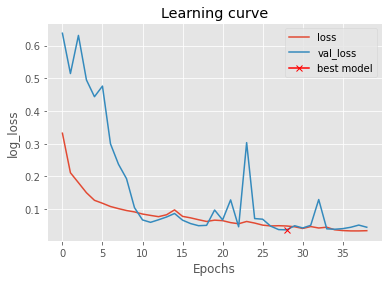

In [15]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.savefig('learning curve.png', dpi=300)

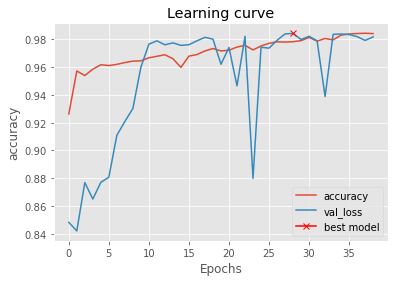

In [19]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_loss")
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.savefig('learning curve acc.png', dpi=300)

In [ ]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)


# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)


# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [46]:
# Predict on train, val and test
preds_train = model.predict(X, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)

449/449 [==============================] - 85s 190ms/step


In [47]:
preds_train_t = preds_train_t.reshape(449, 400, 640)

In [48]:
preds_train_t.shape

(449, 400, 640)

In [ ]:
X_image = X.reshape(449, 400, 640)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


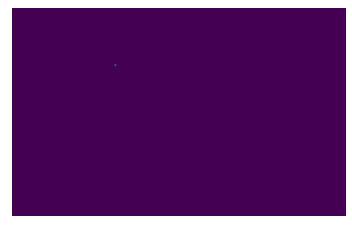

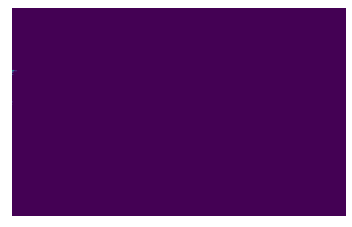

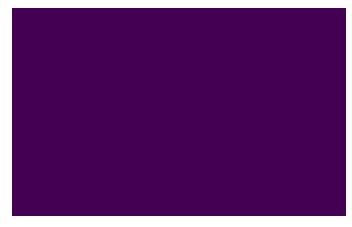

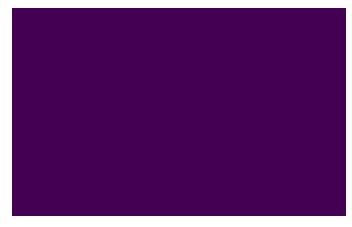

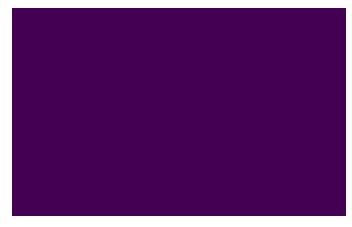

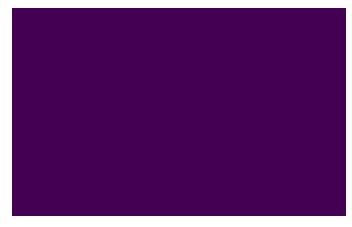

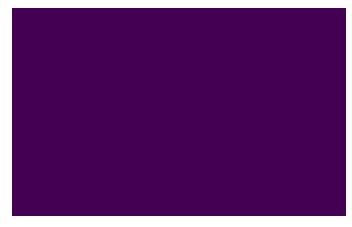

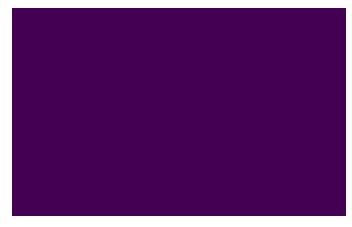

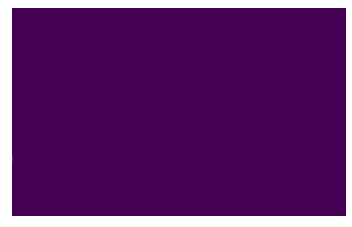

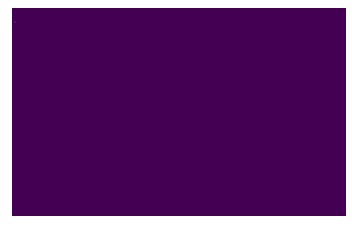

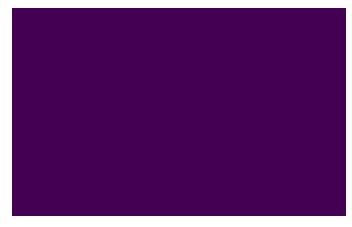

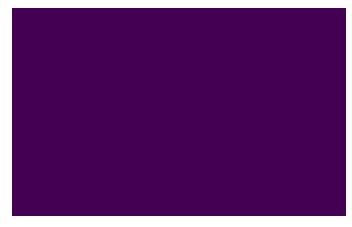

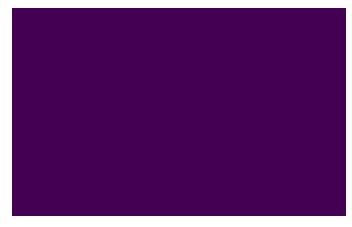

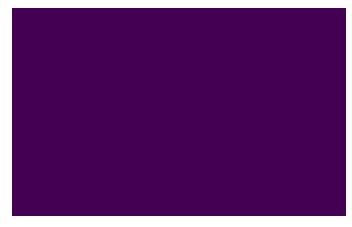

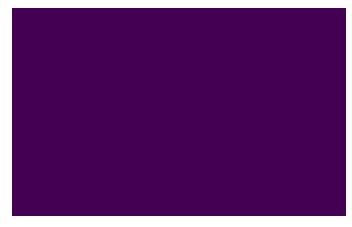

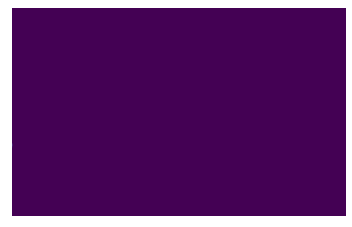

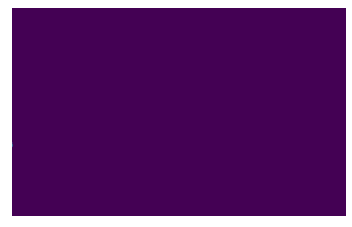

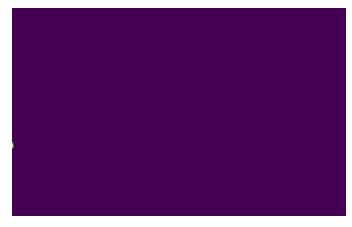

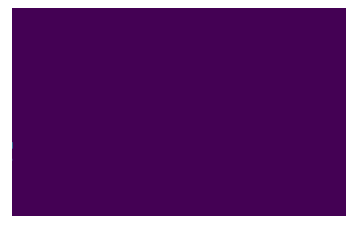

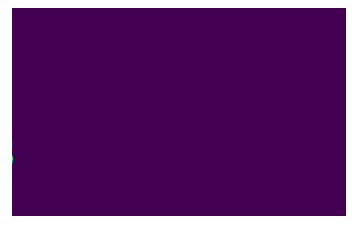

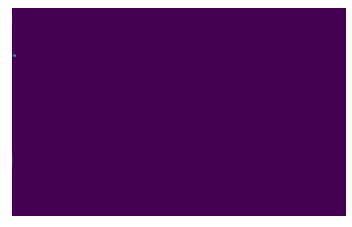

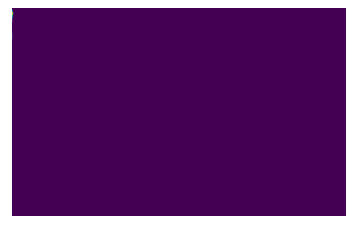

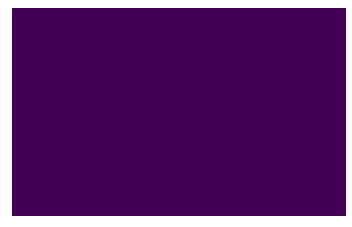

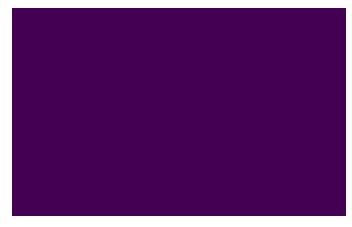

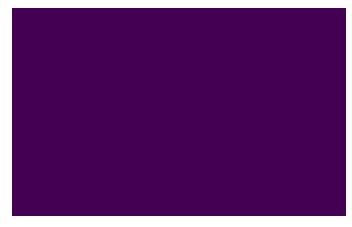

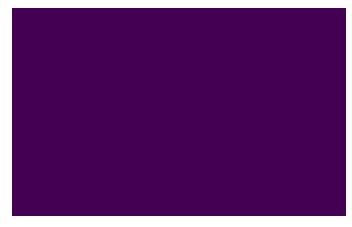

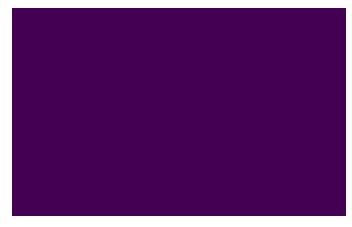

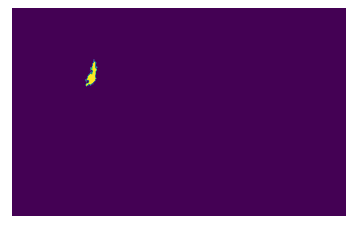

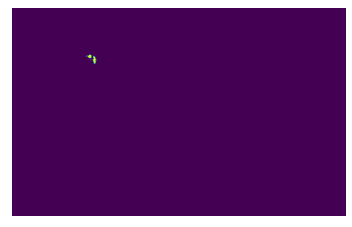

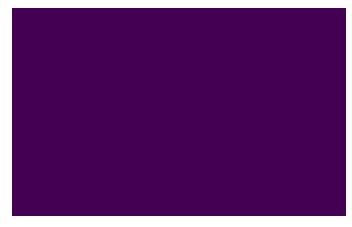

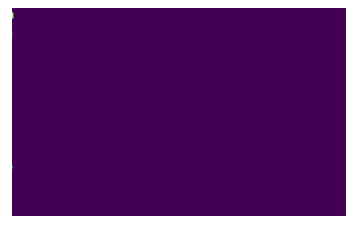

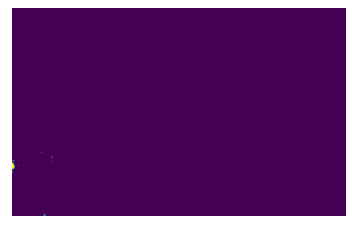

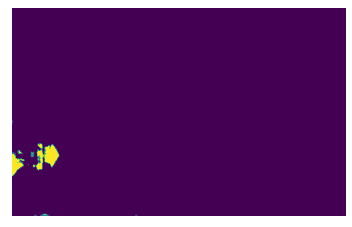

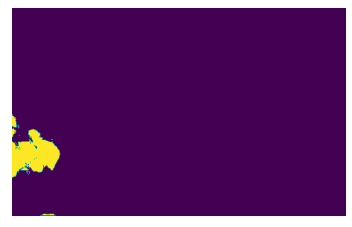

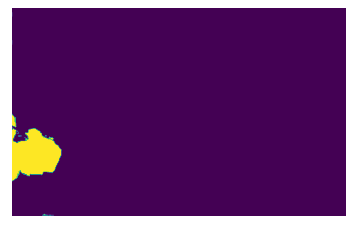

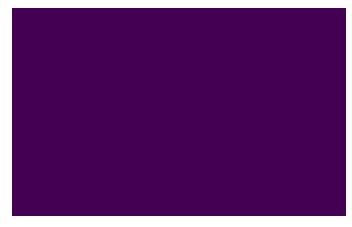

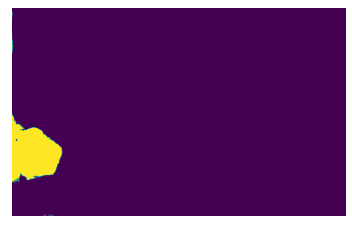

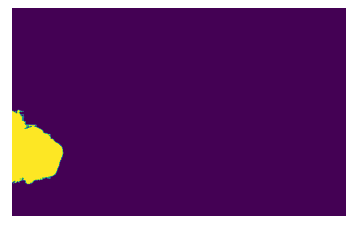

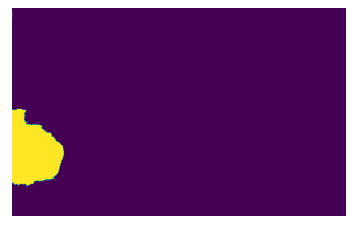

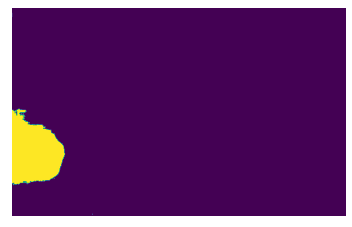

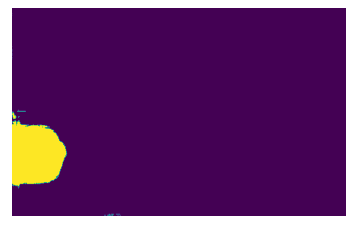

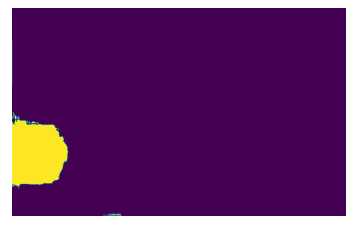

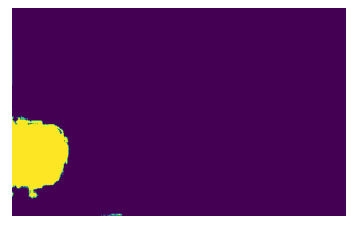

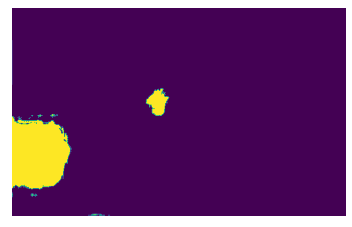

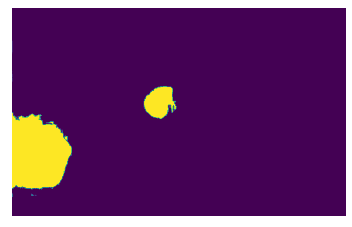

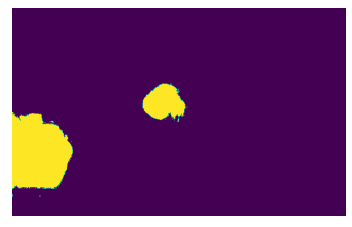

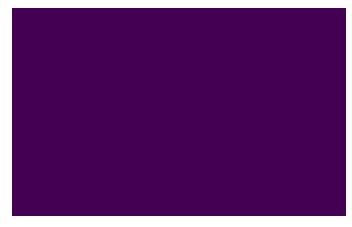

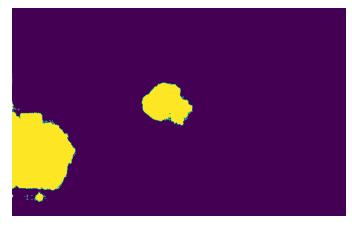

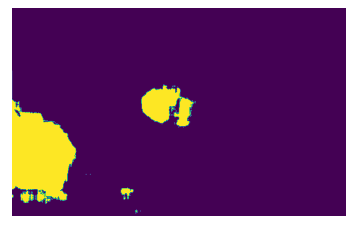

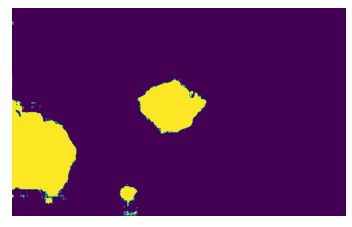

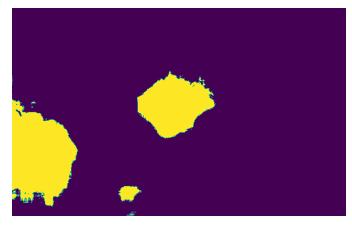

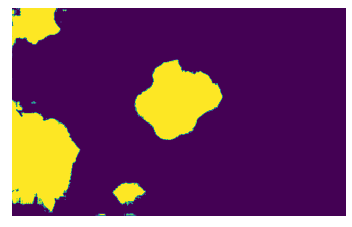

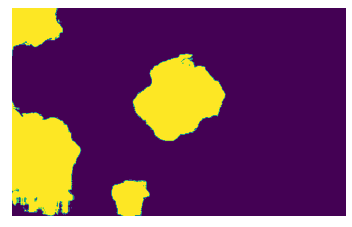

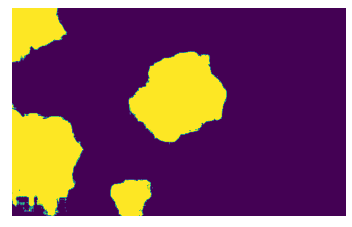

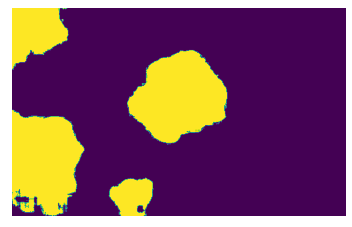

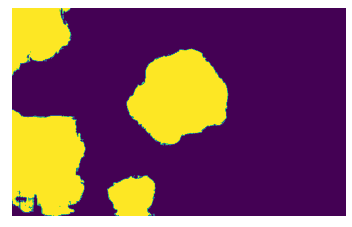

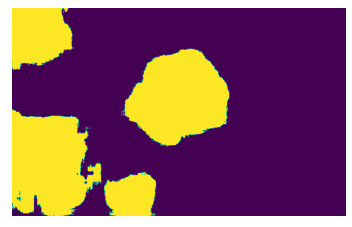

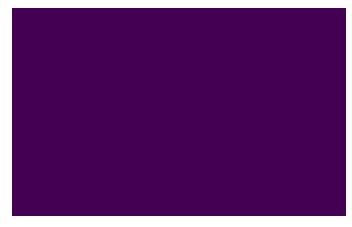

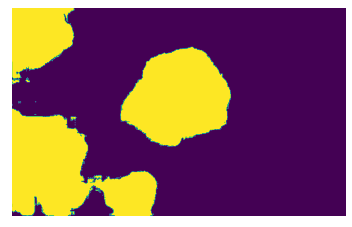

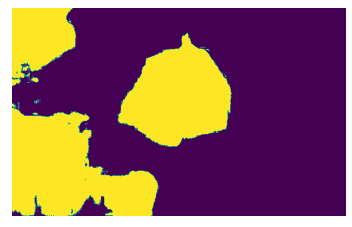

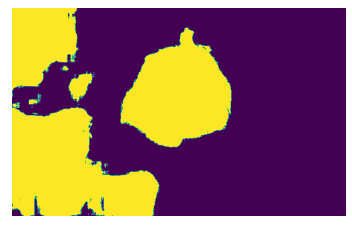

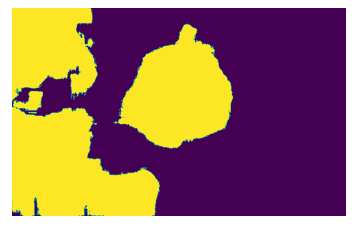

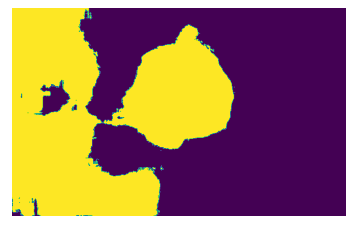

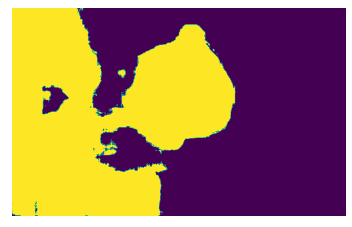

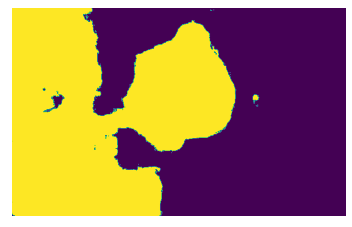

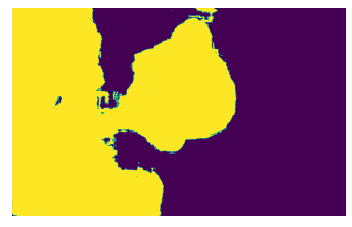

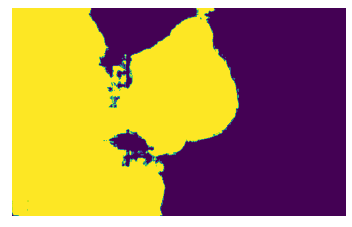

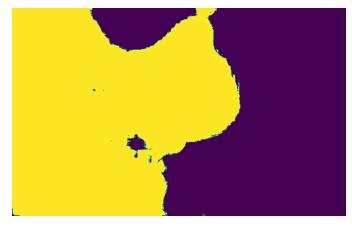

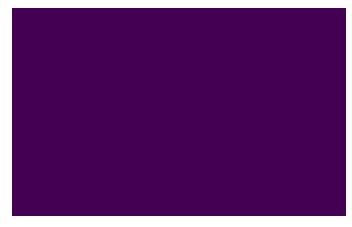

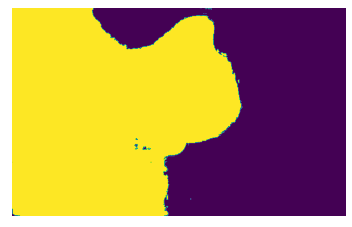

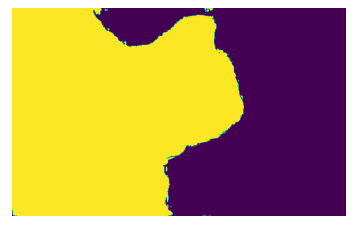

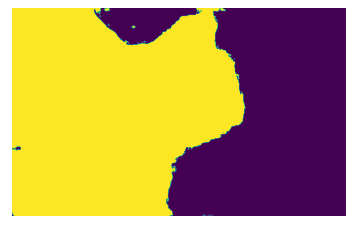

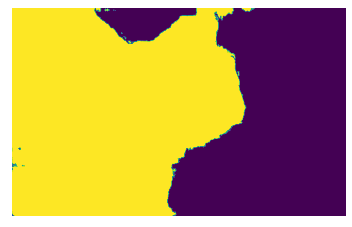

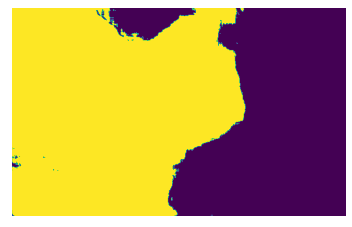

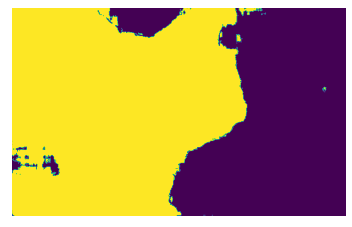

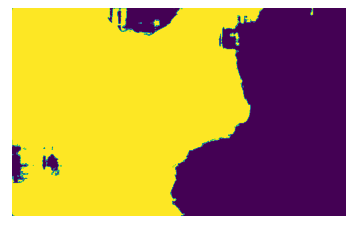

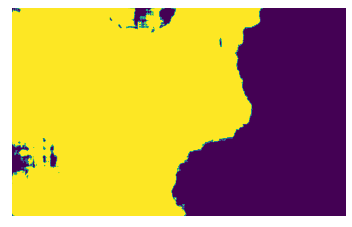

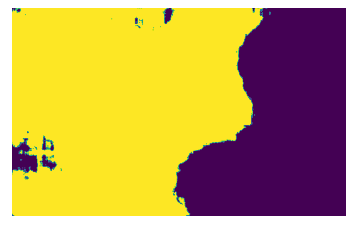

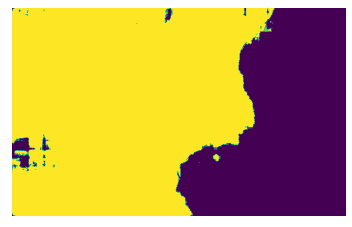

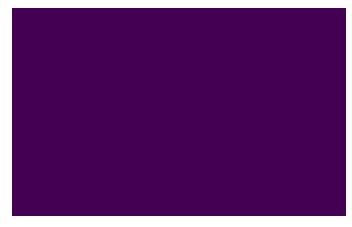

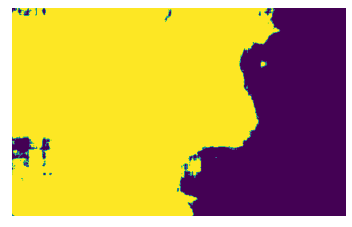

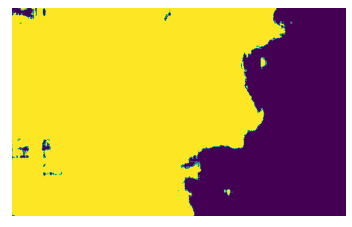

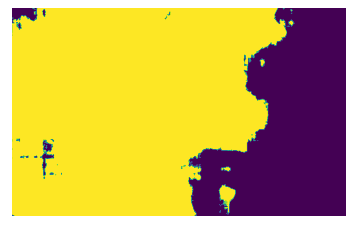

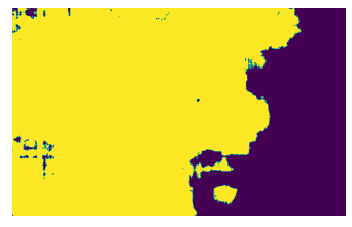

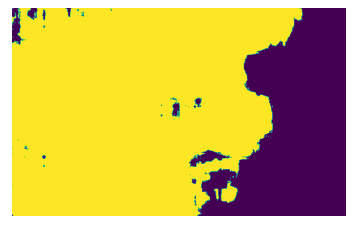

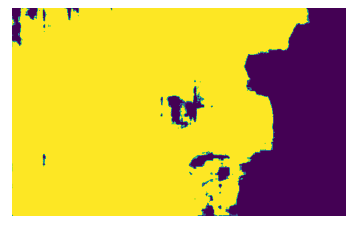

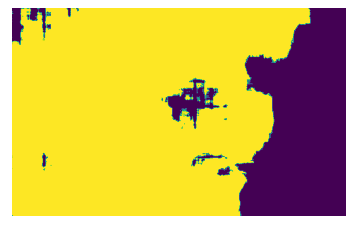

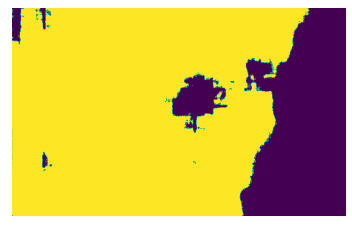

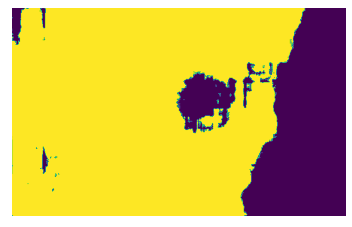

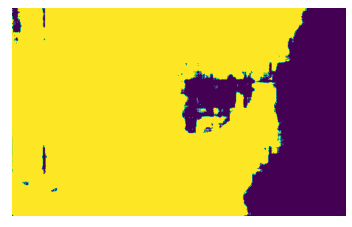

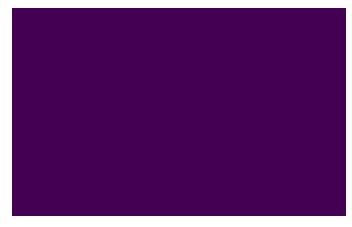

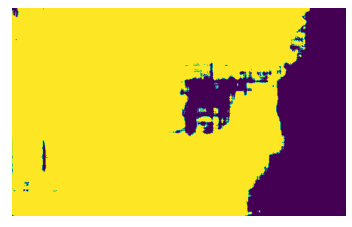

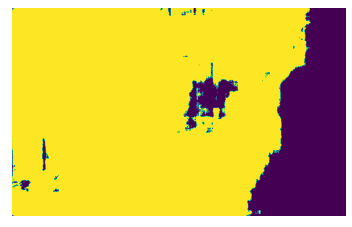

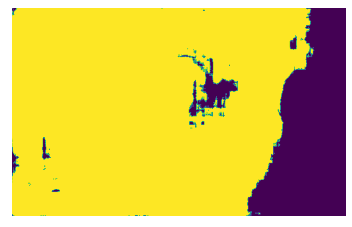

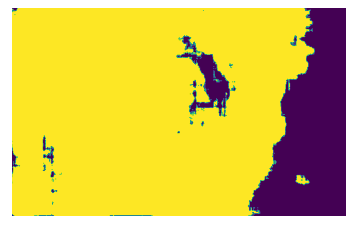

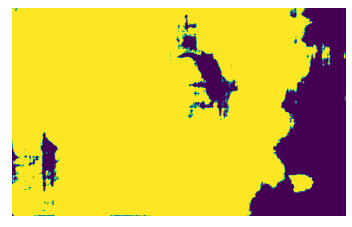

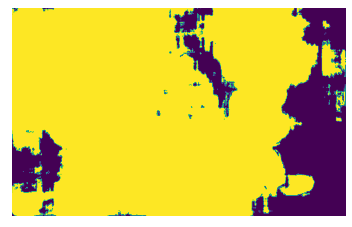

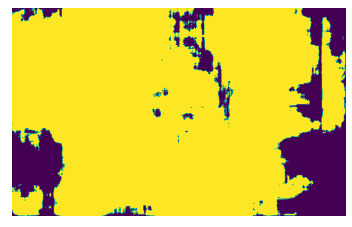

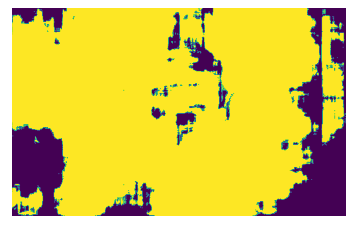

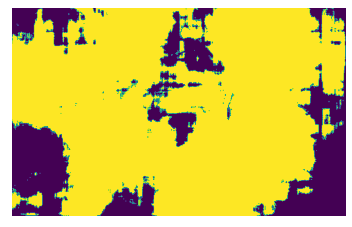

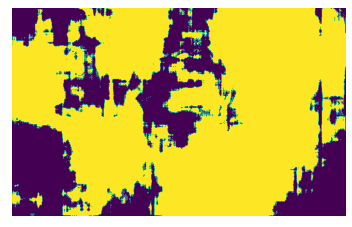

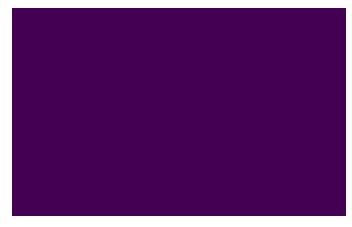

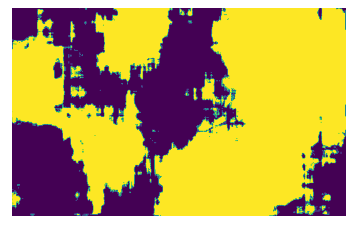

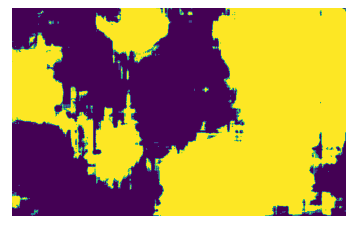

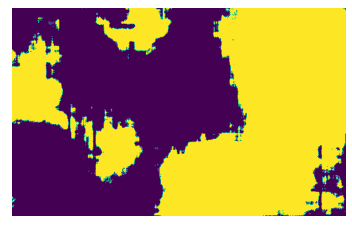

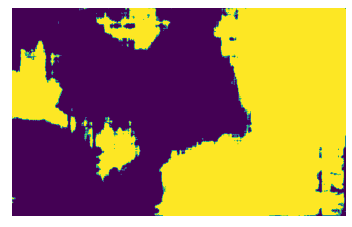

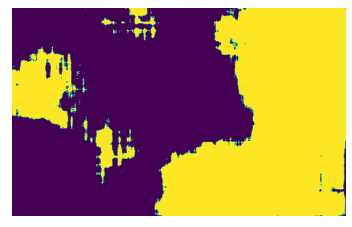

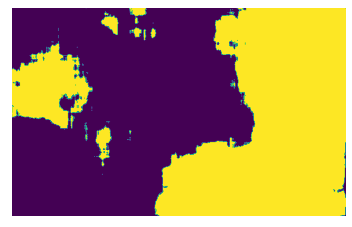

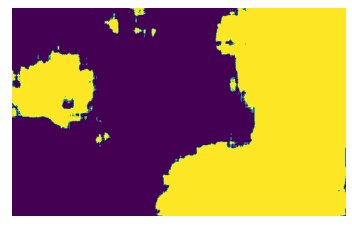

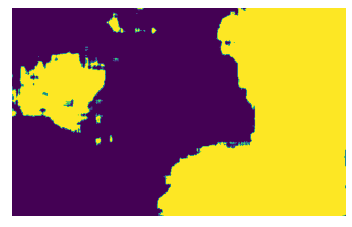

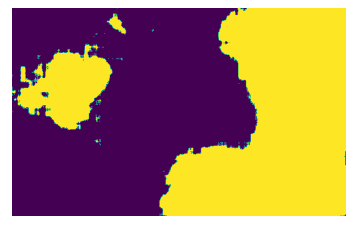

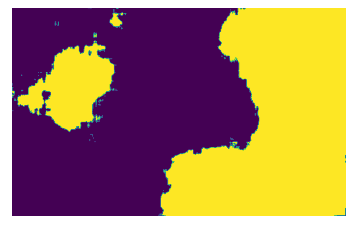

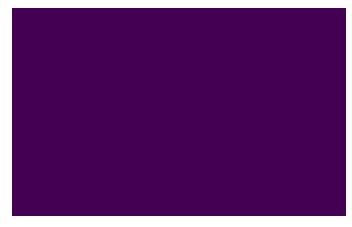

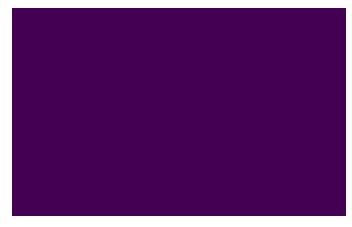

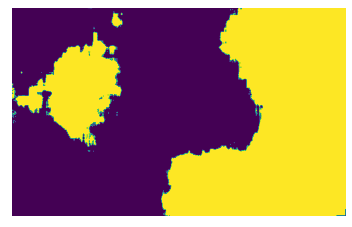

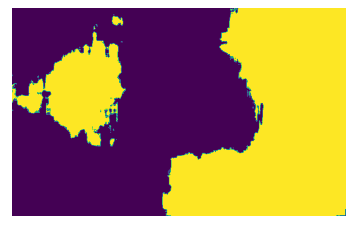

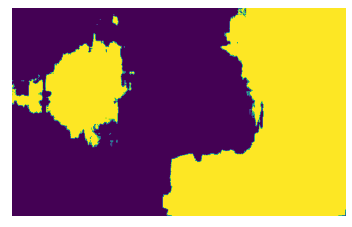

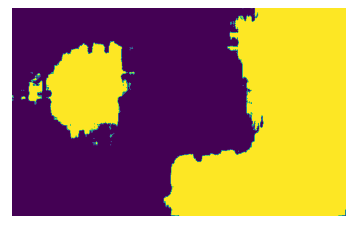

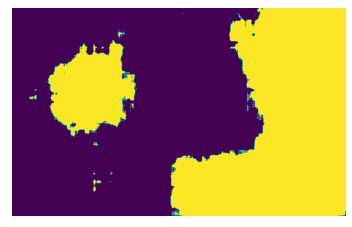

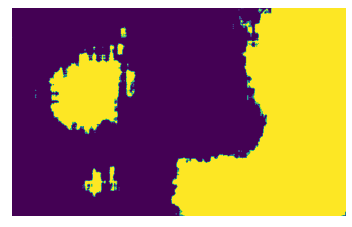

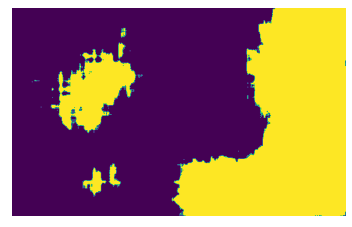

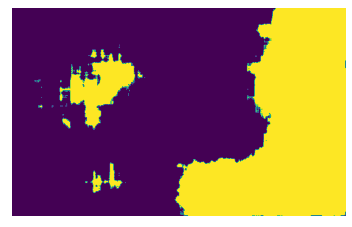

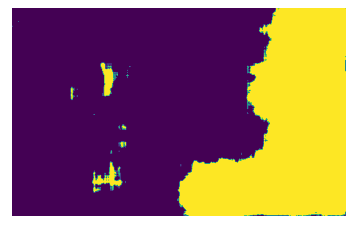

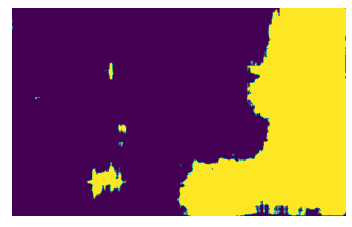

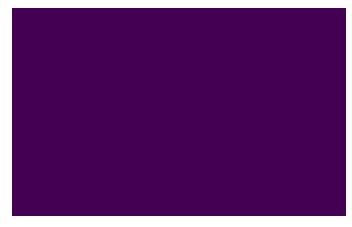

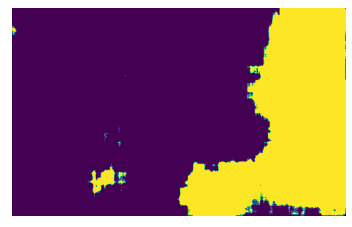

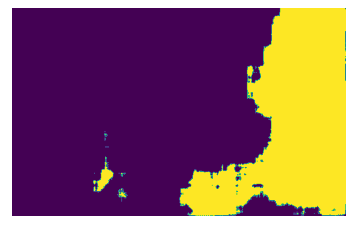

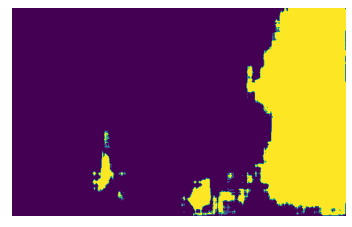

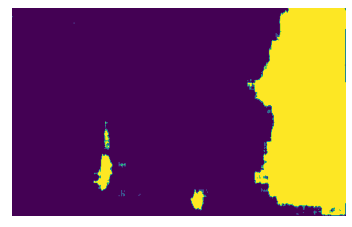

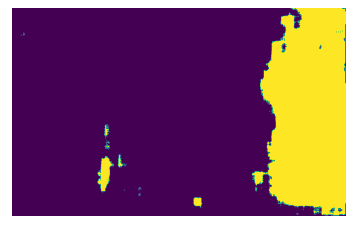

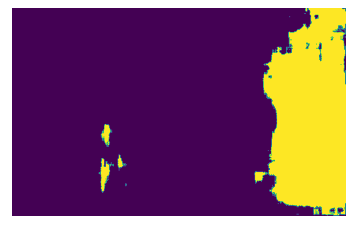

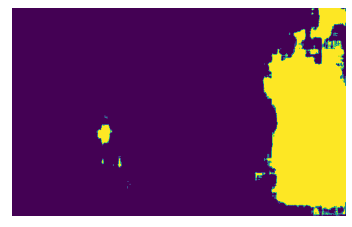

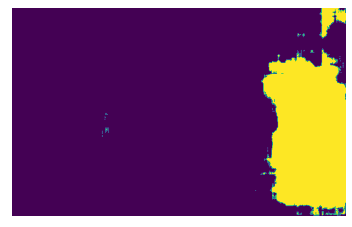

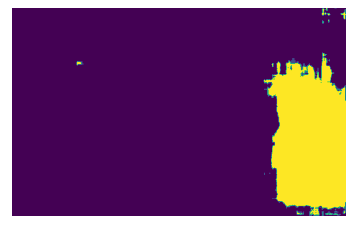

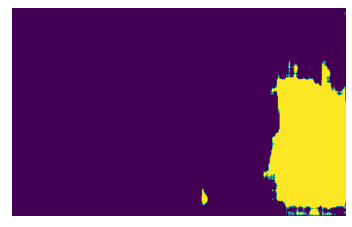

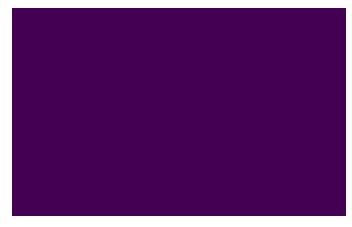

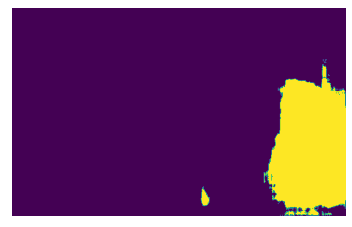

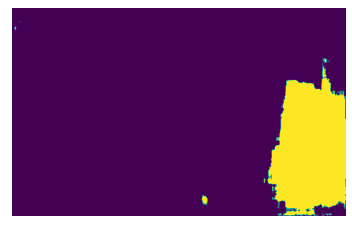

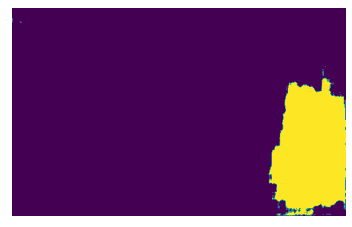

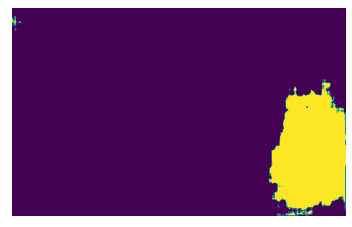

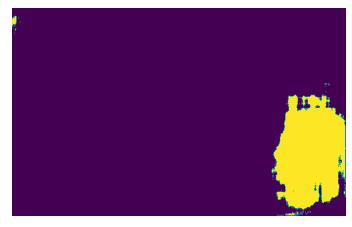

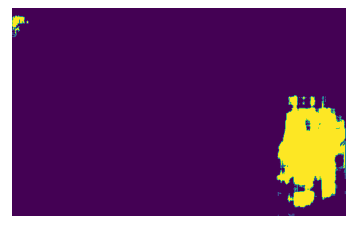

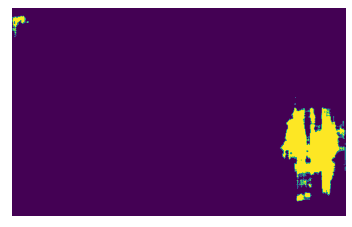

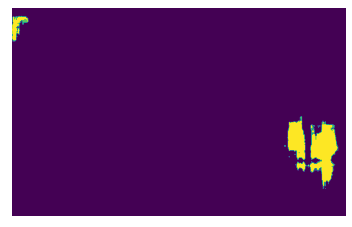

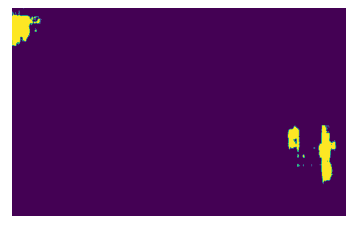

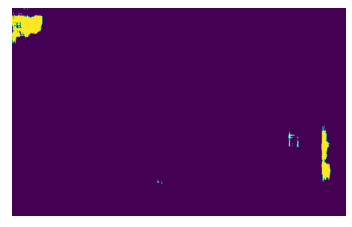

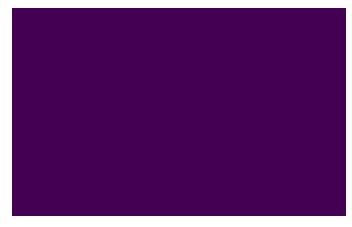

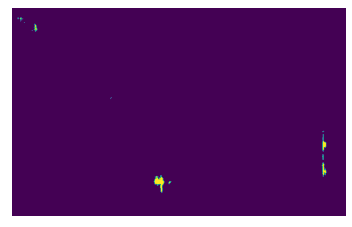

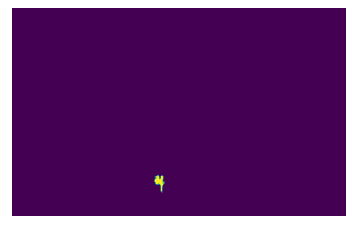

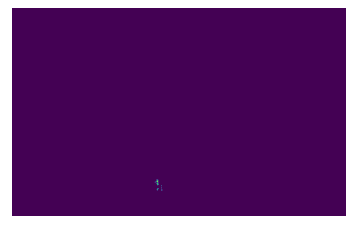

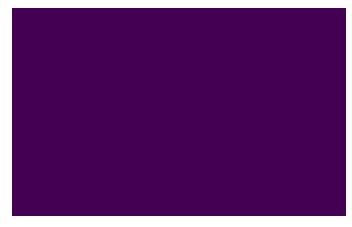

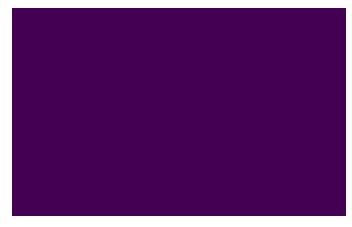

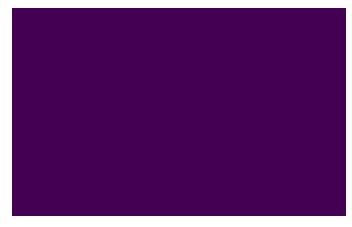

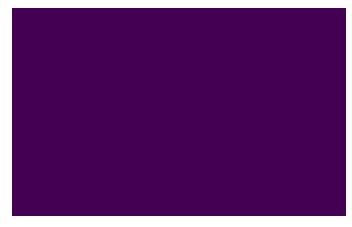

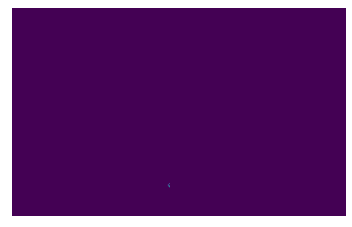

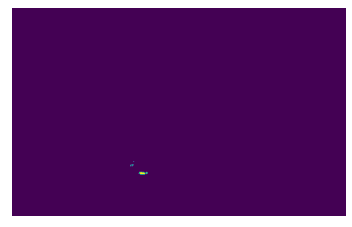

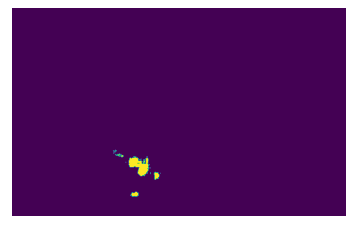

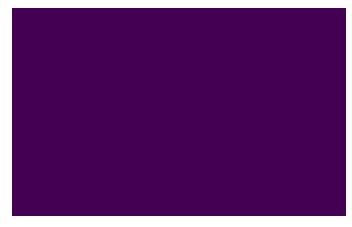

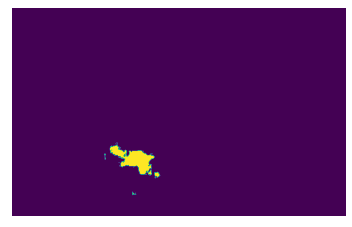

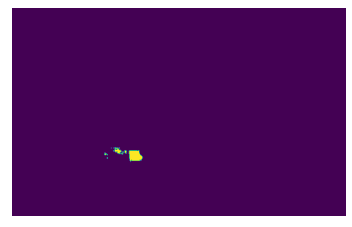

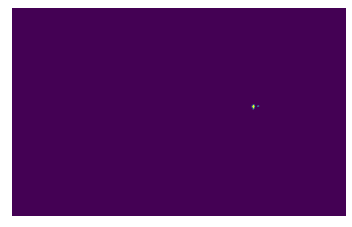

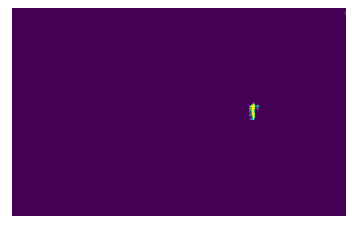

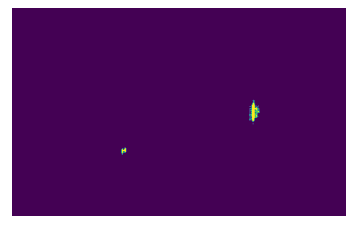

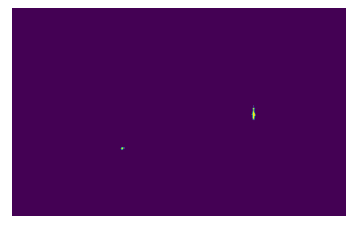

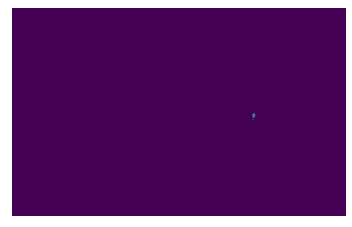

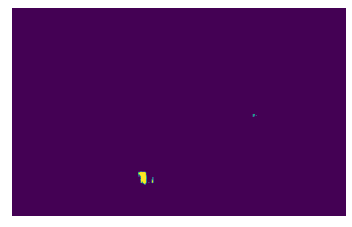

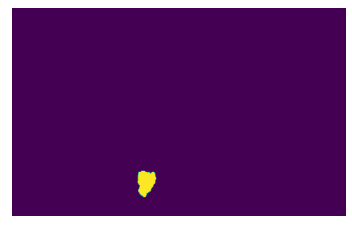

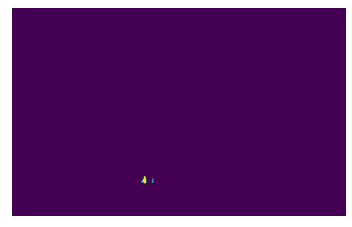

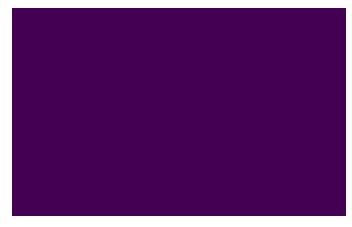

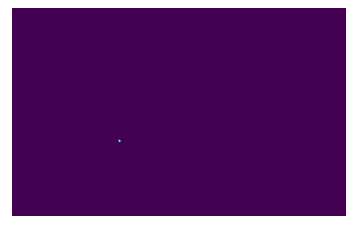

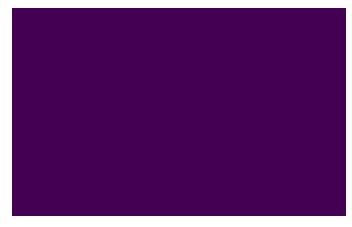

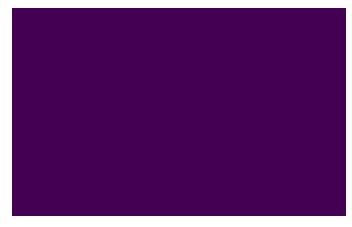

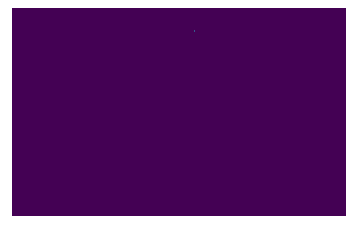

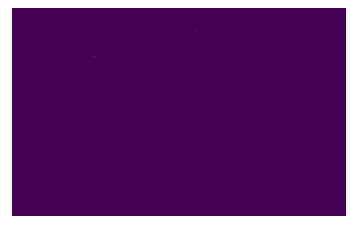

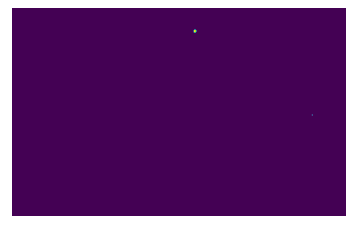

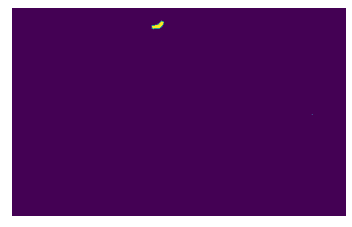

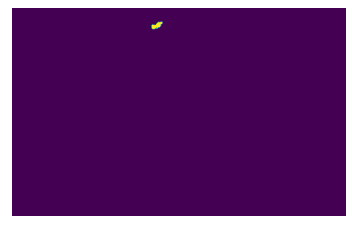

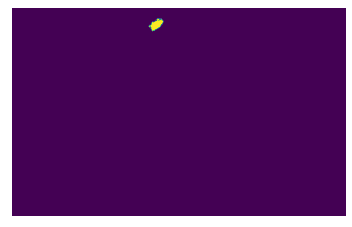

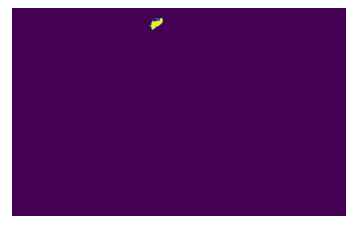

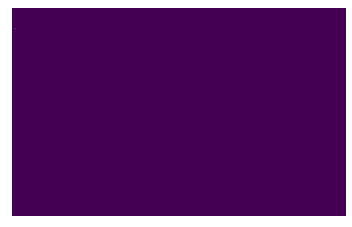

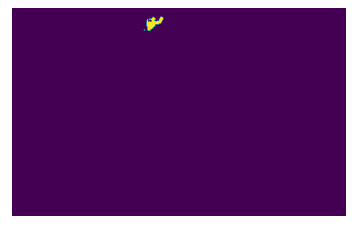

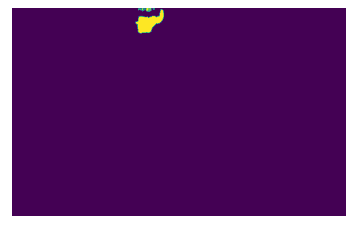

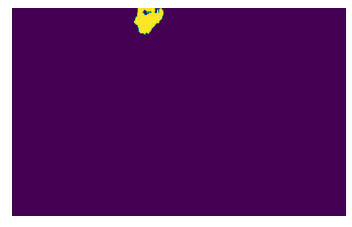

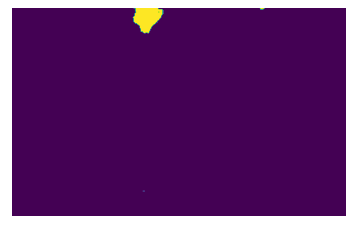

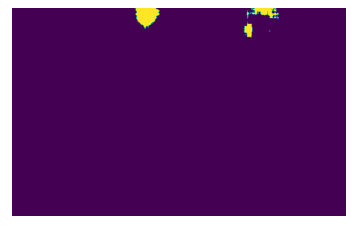

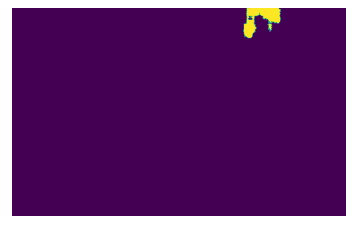

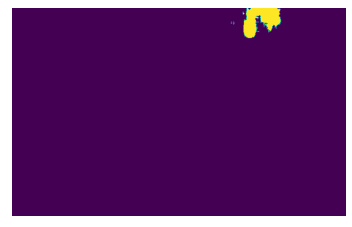

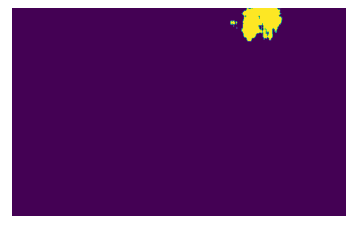

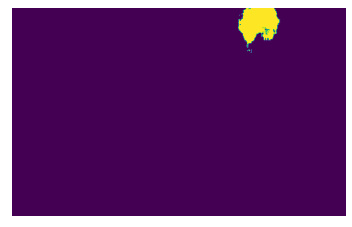

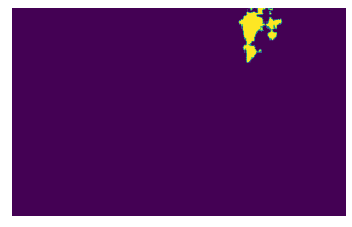

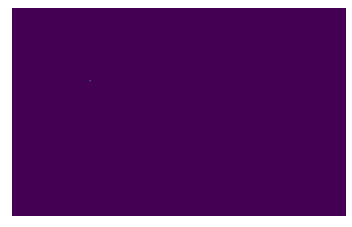

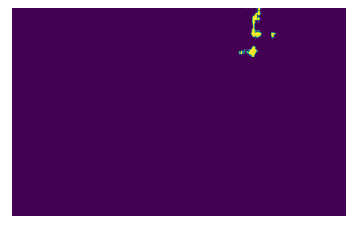

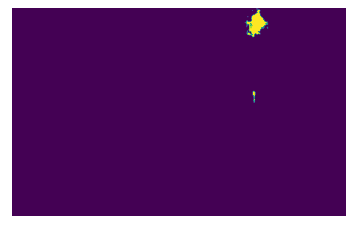

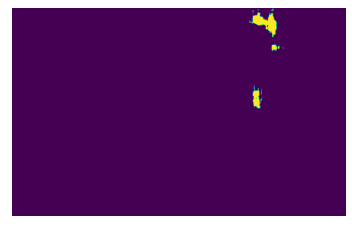

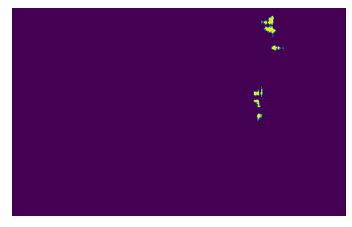

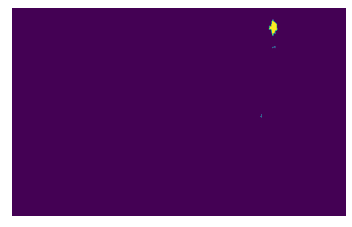

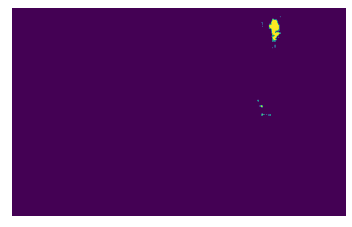

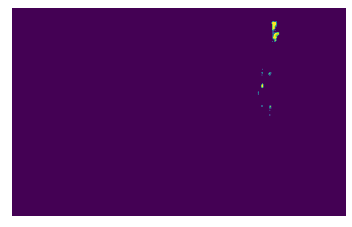

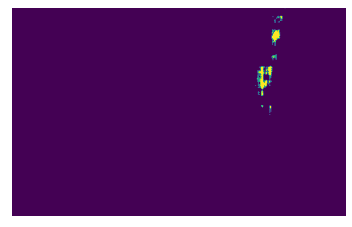

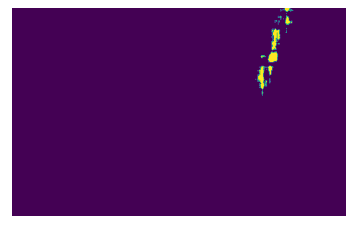

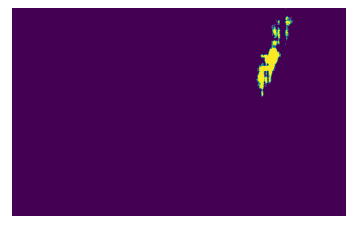

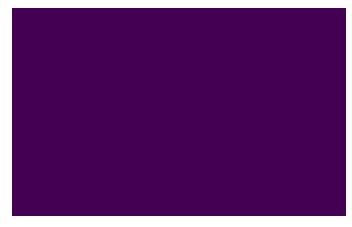

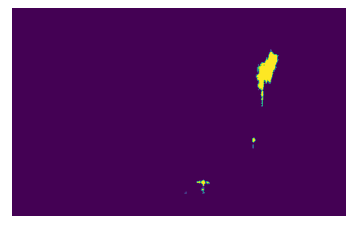

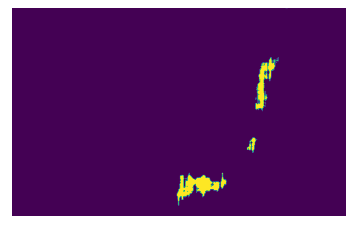

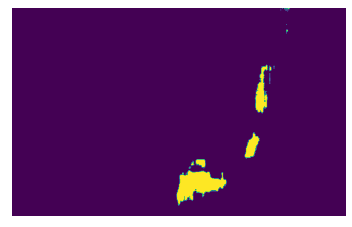

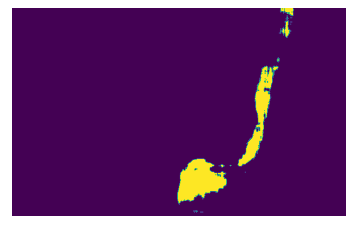

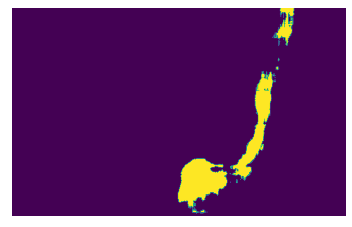

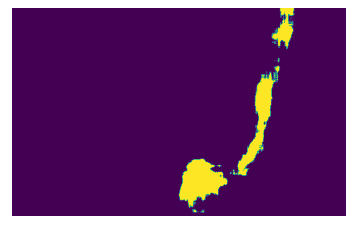

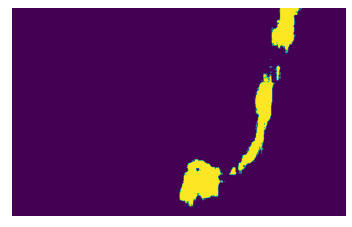

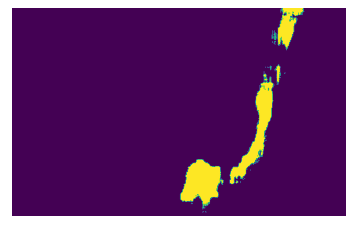

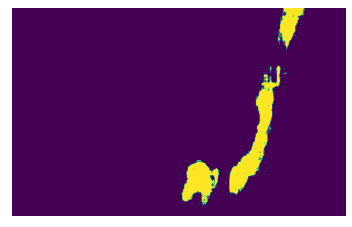

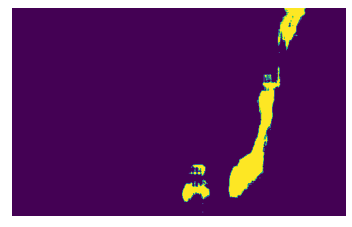

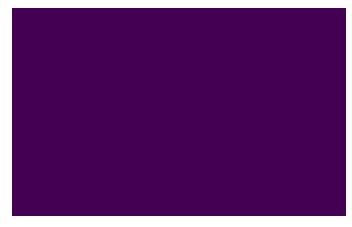

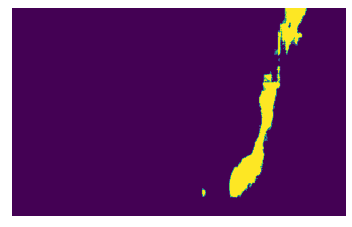

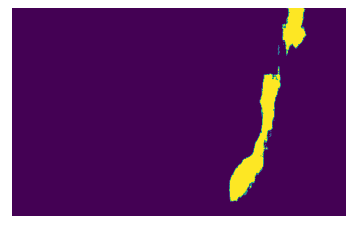

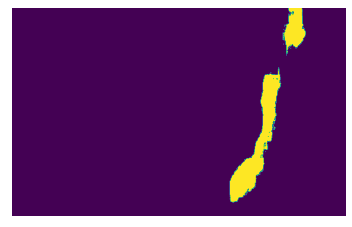

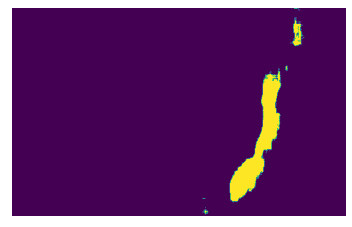

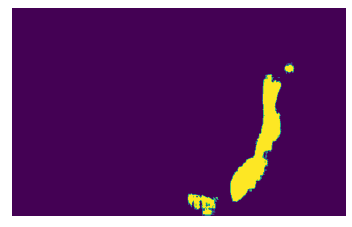

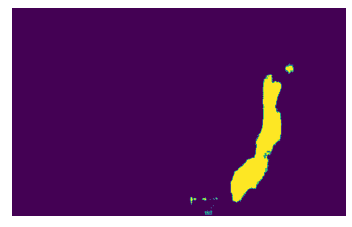

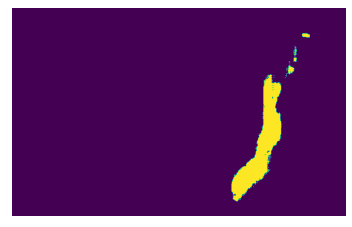

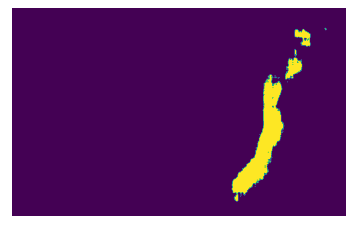

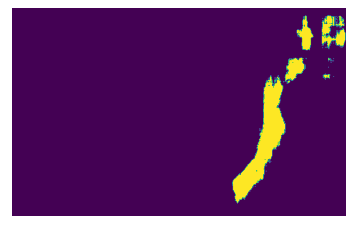

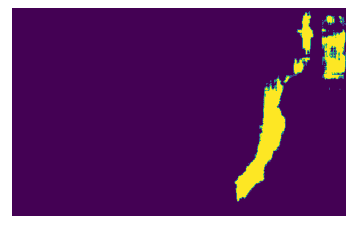

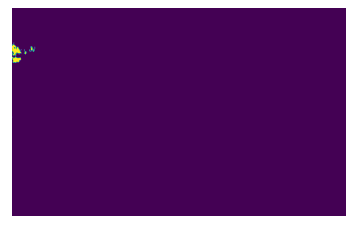

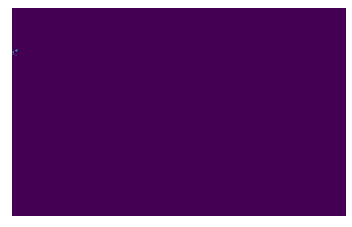

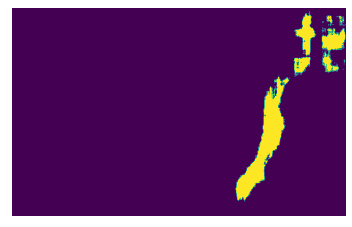

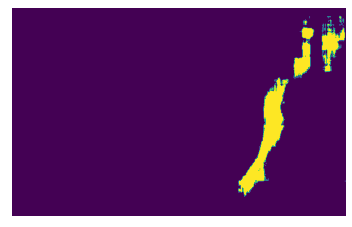

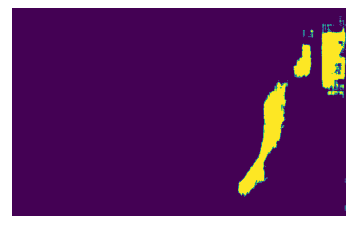

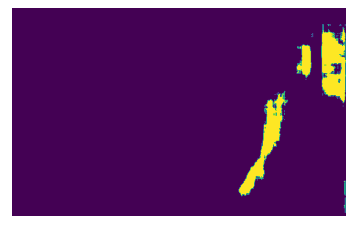

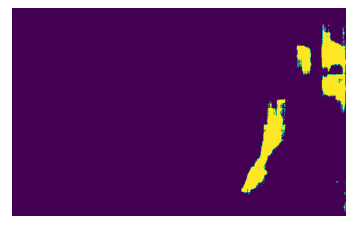

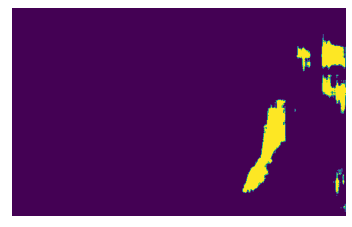

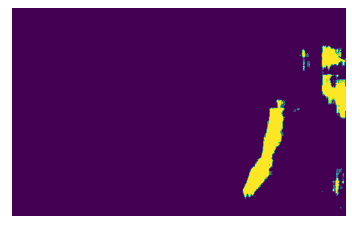

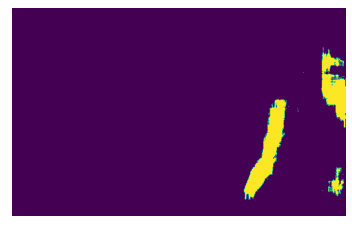

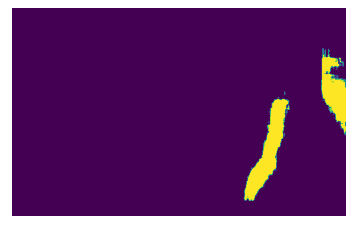

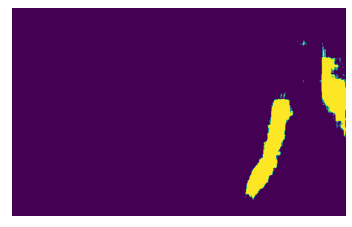

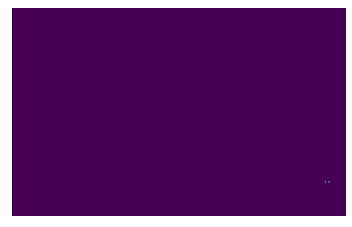

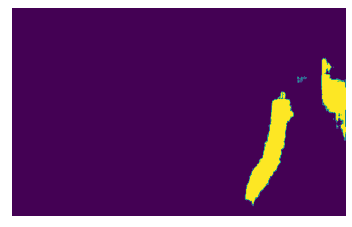

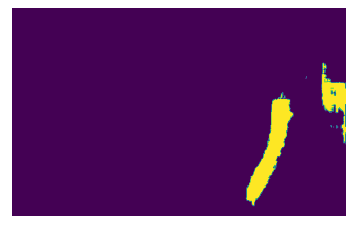

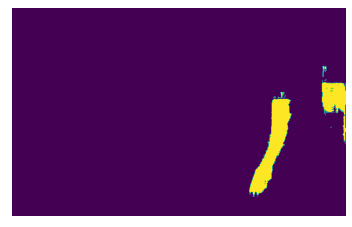

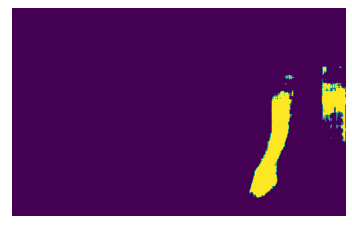

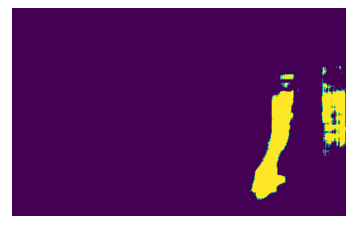

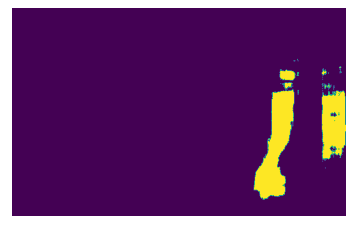

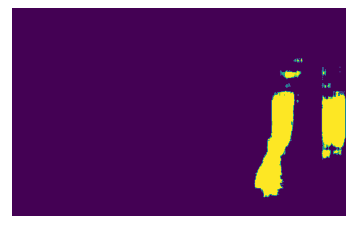

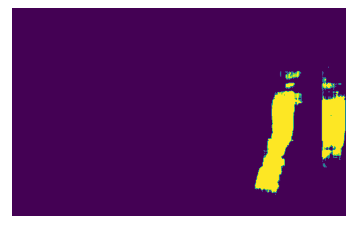

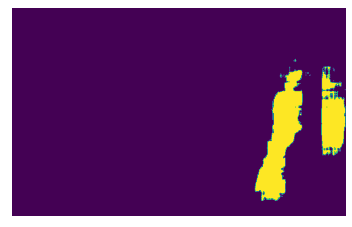

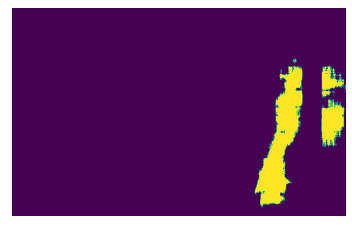

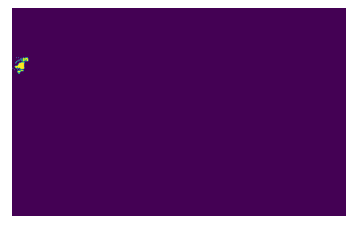

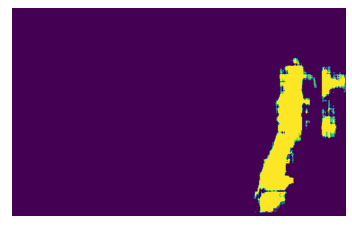

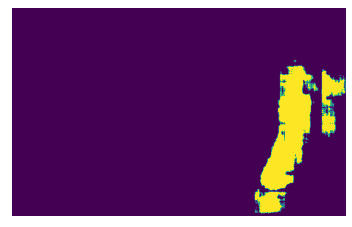

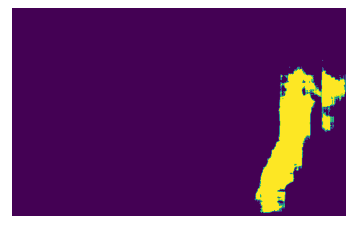

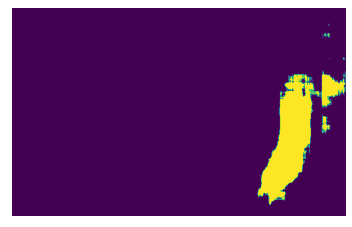

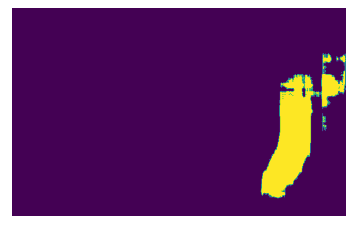

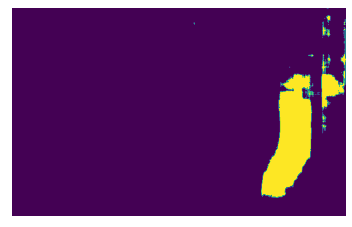

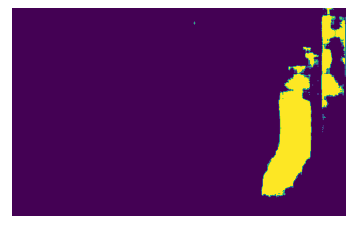

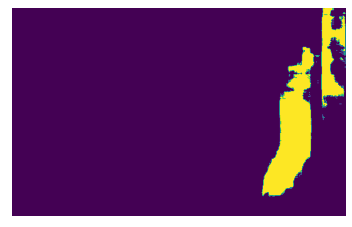

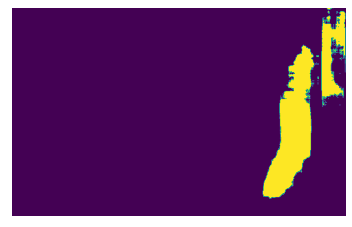

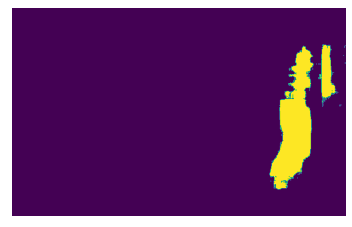

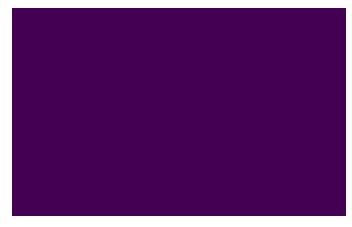

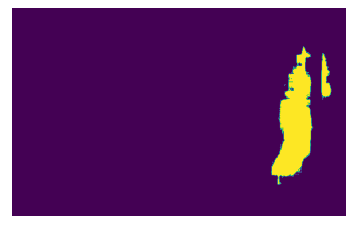

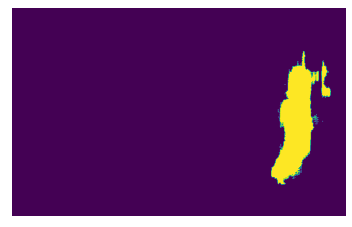

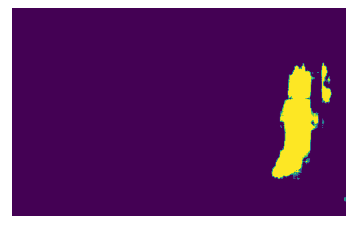

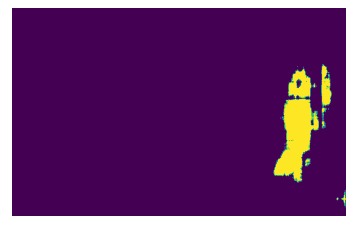

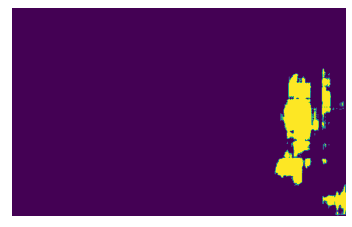

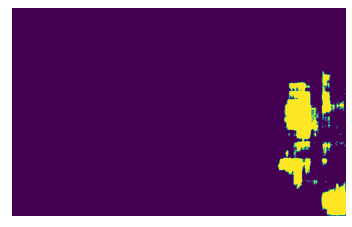

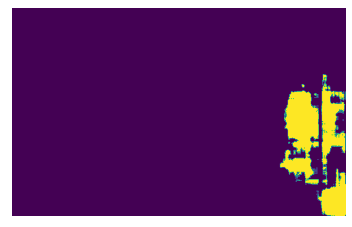

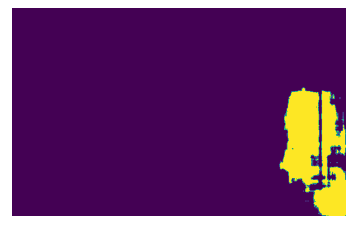

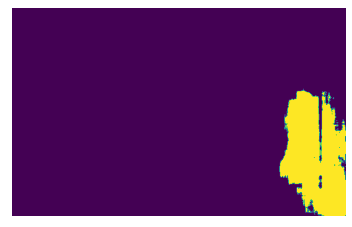

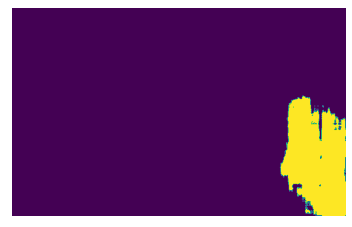

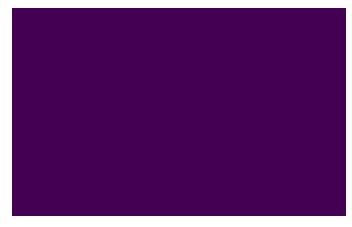

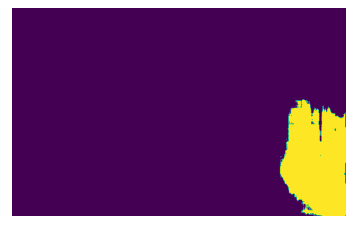

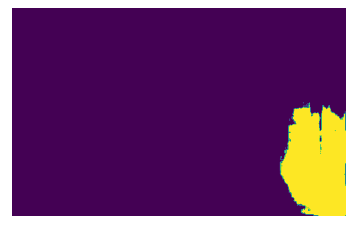

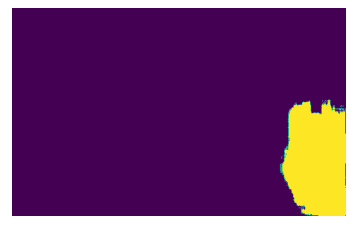

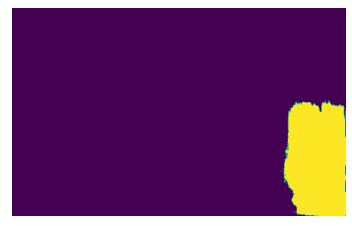

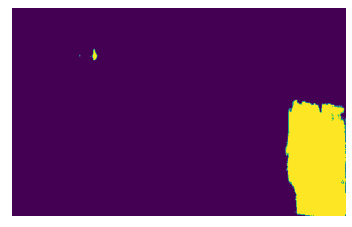

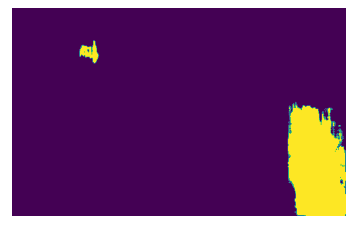

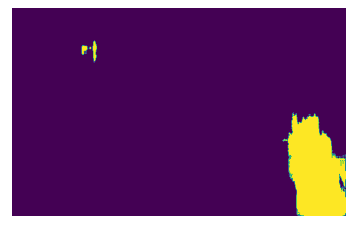

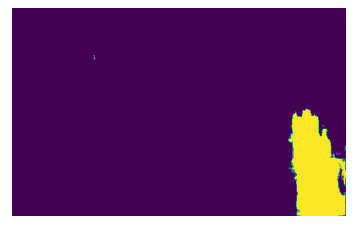

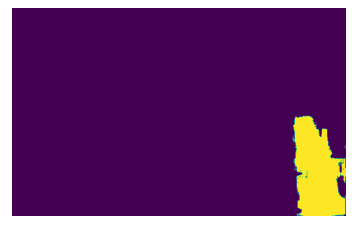

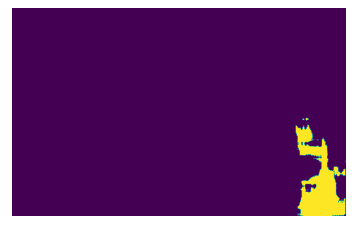

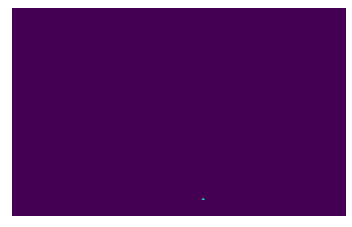

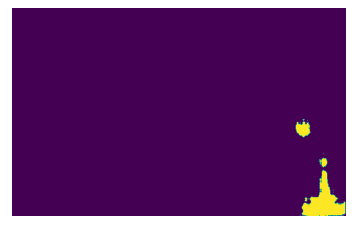

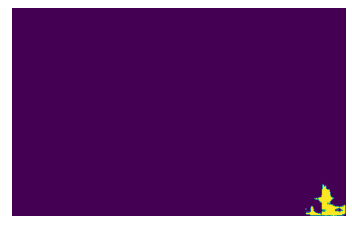

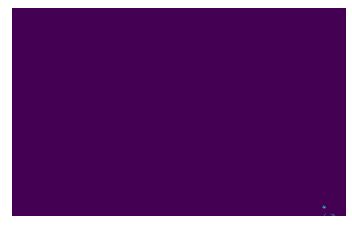

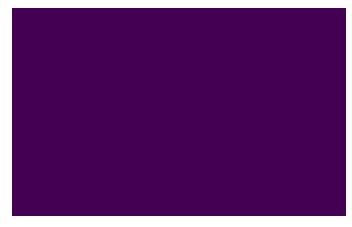

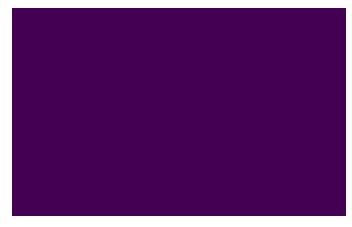

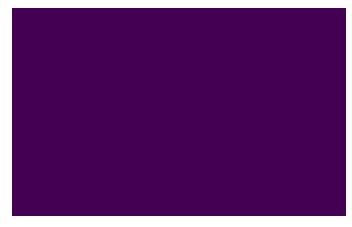

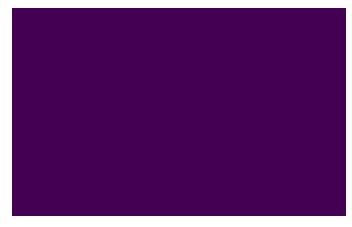

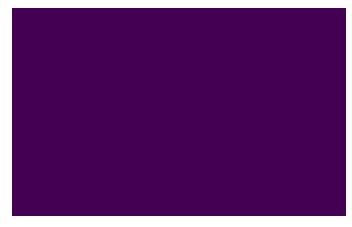

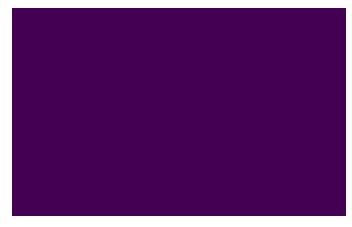

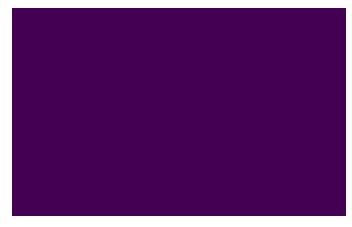

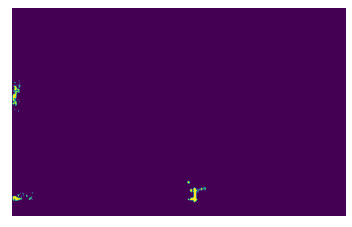

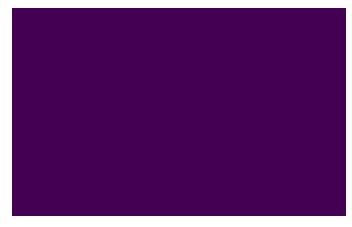

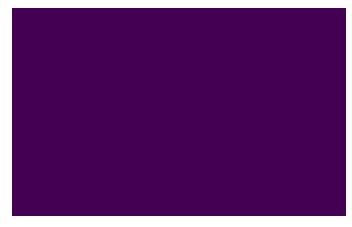

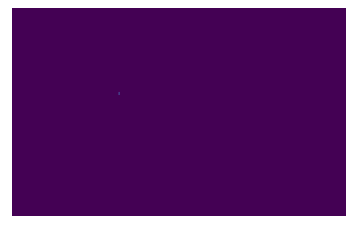

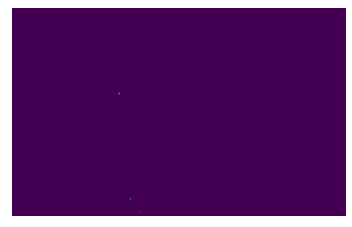

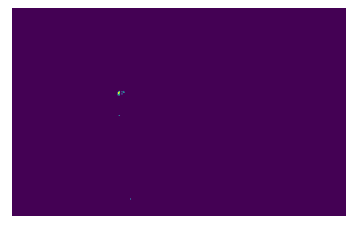

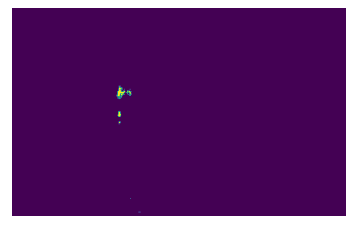

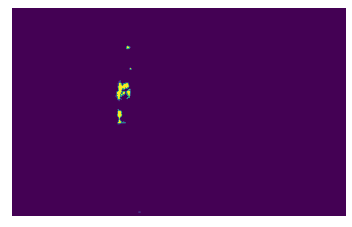

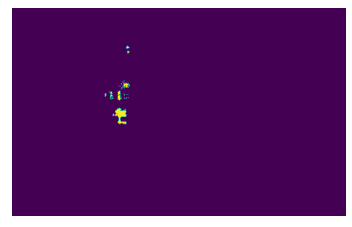

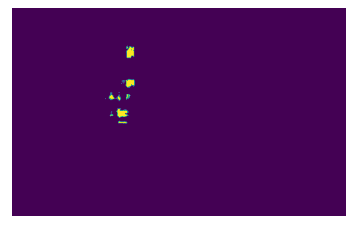

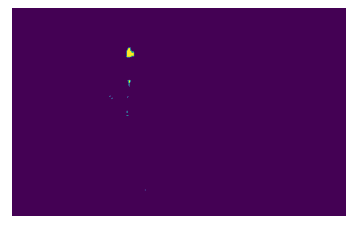

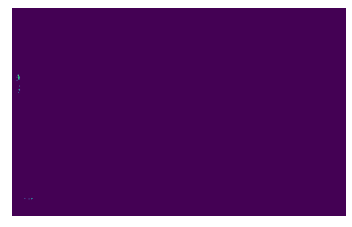

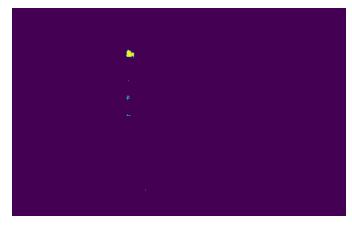

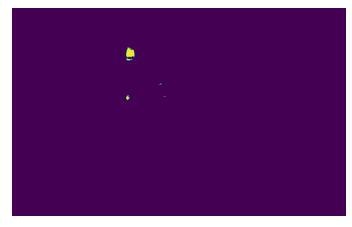

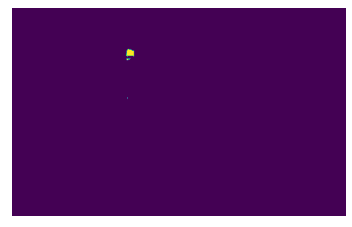

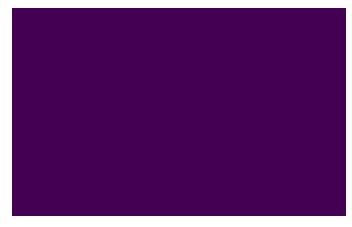

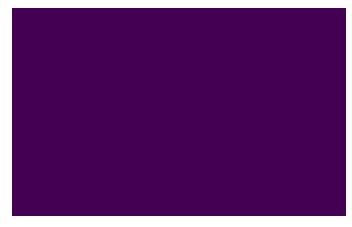

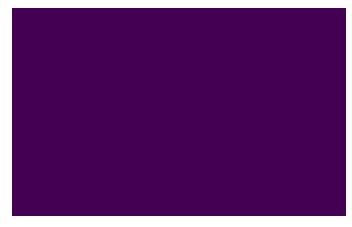

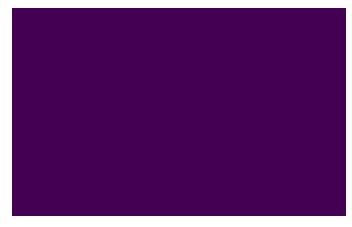

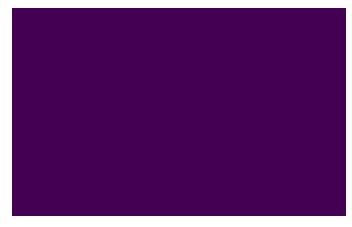

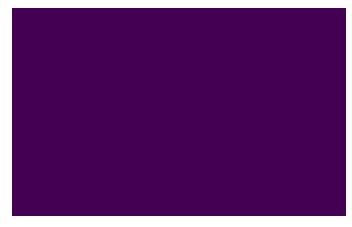

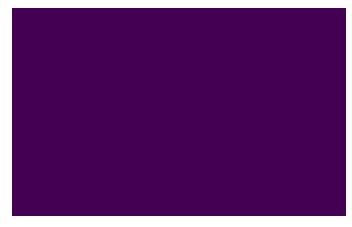

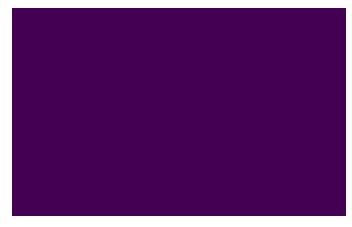

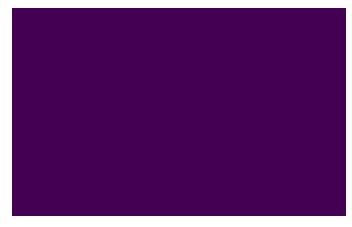

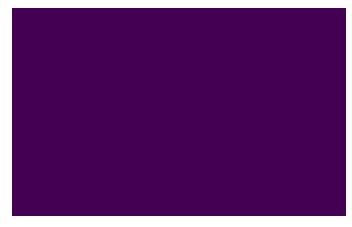

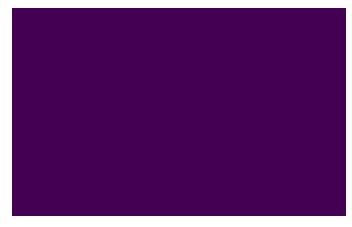

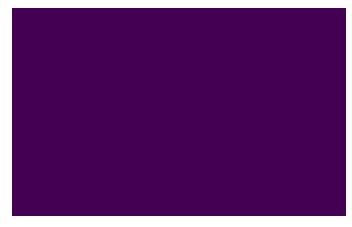

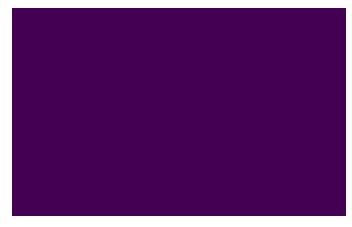

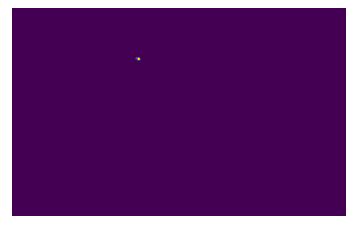

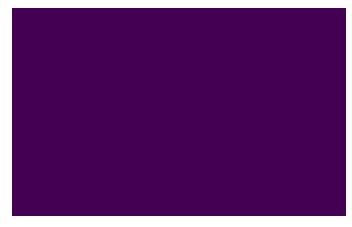

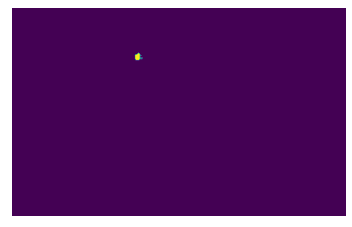

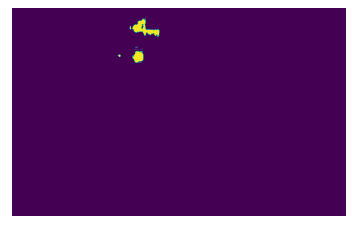

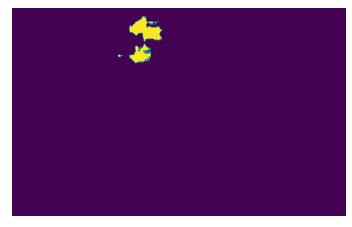

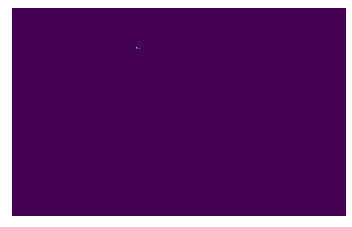

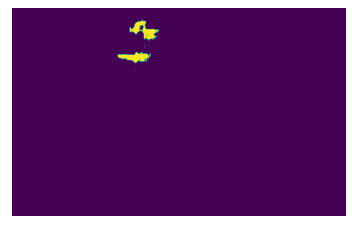

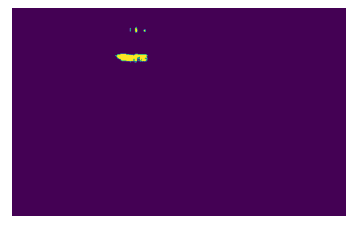

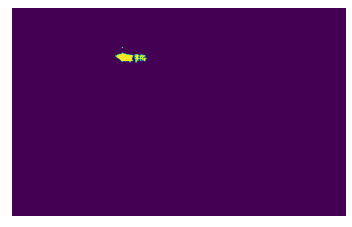

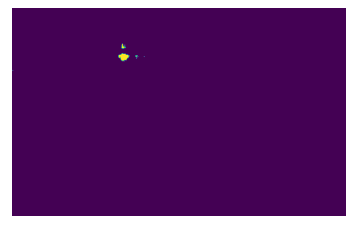

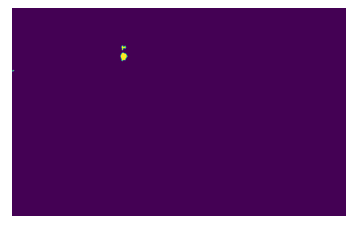

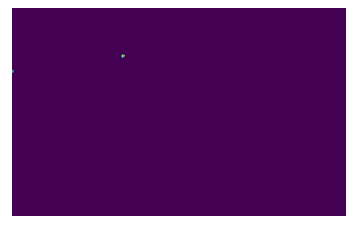

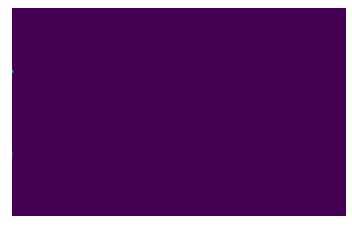

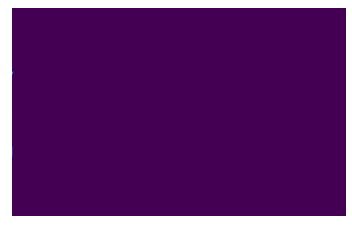

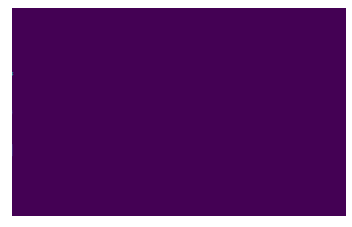

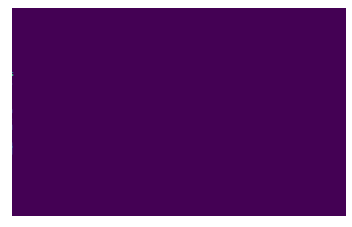

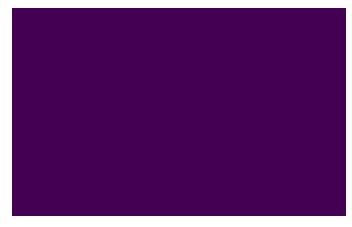

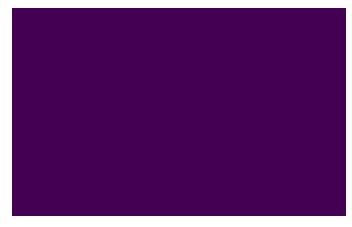

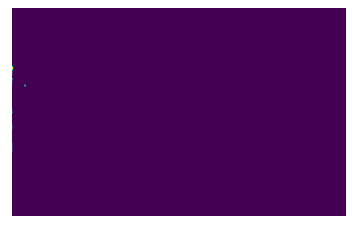

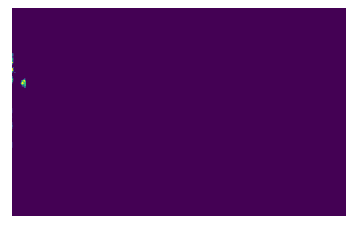

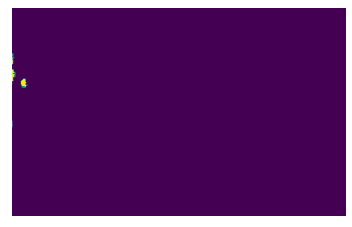

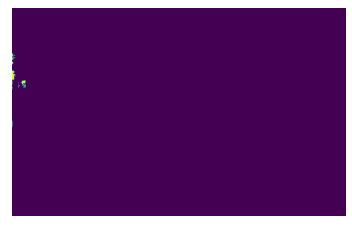

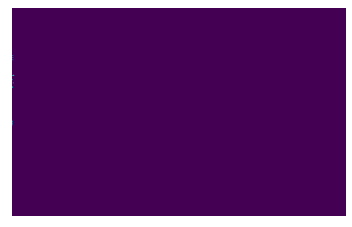

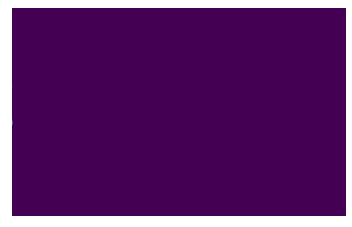

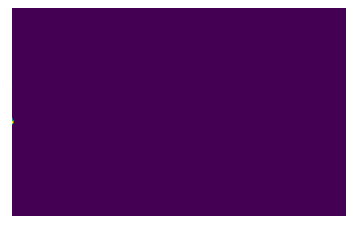

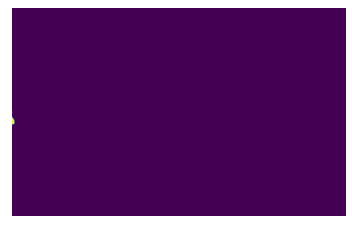

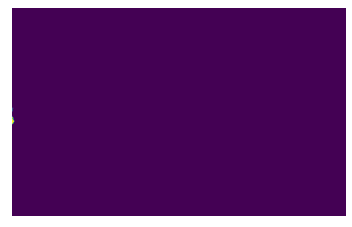

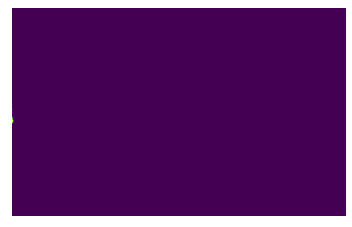

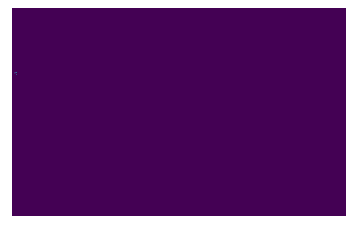

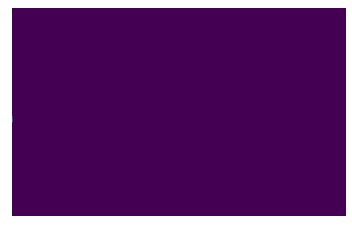

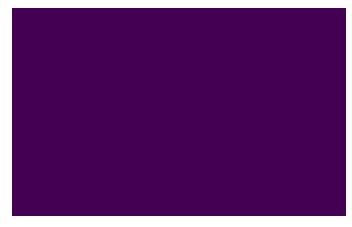

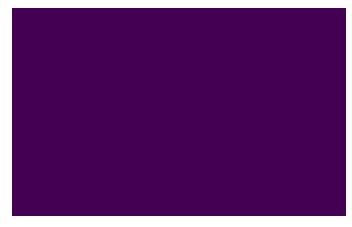

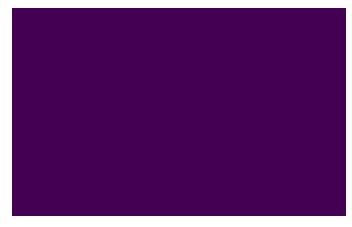

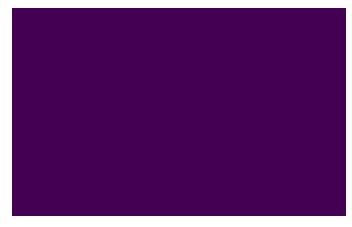

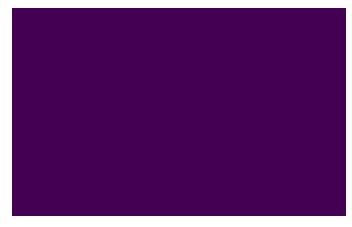

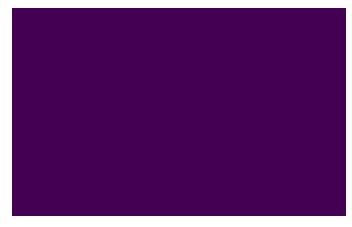

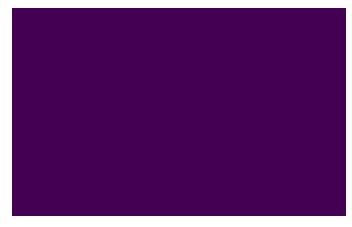

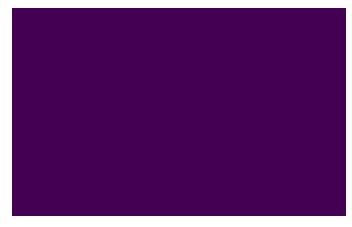

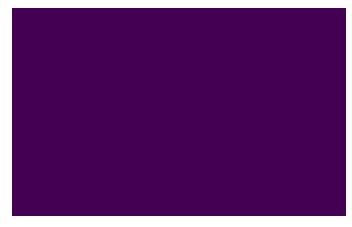

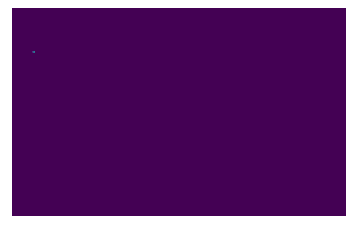

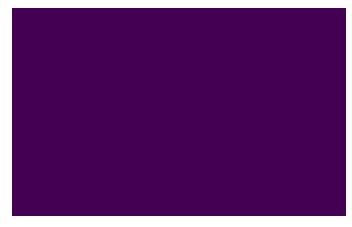

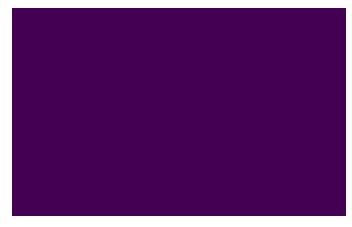

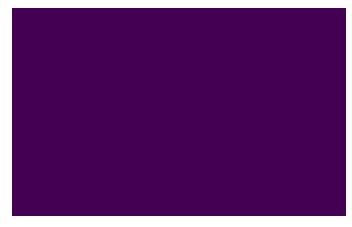

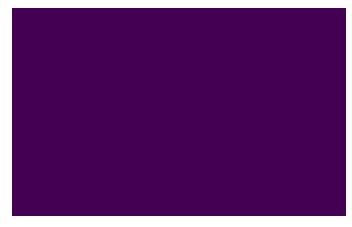

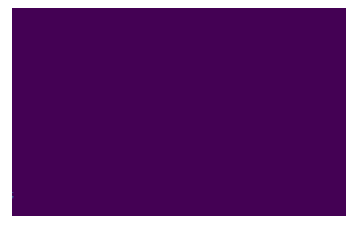

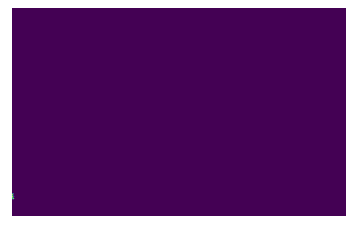

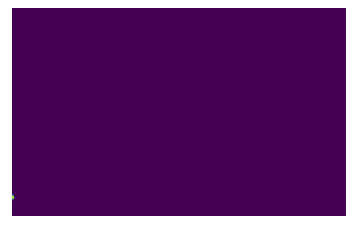

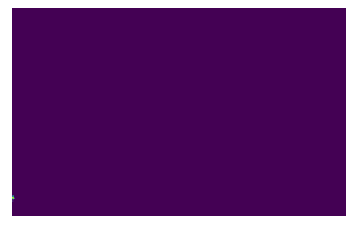

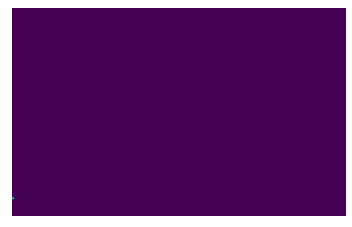

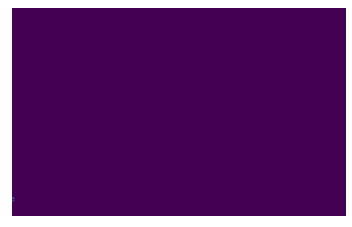

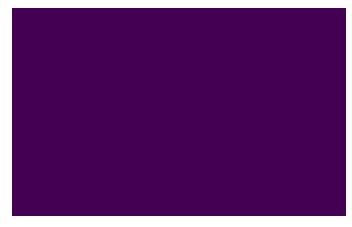

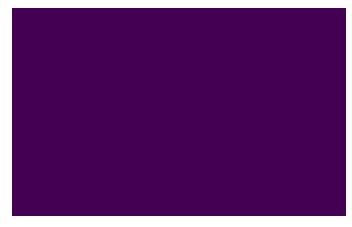

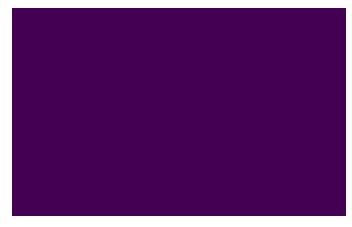

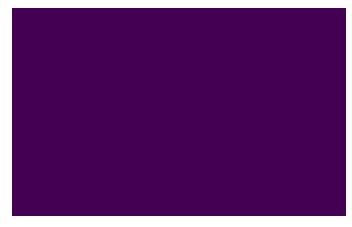

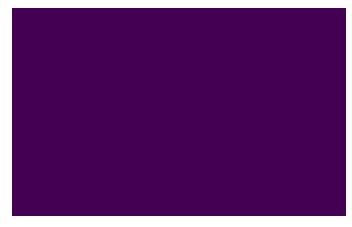

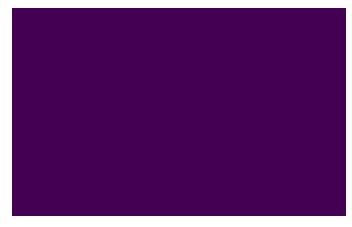

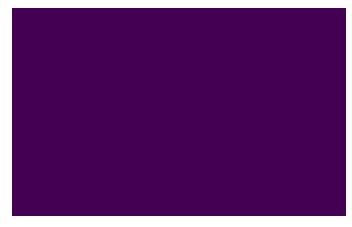

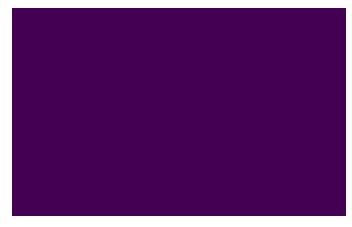

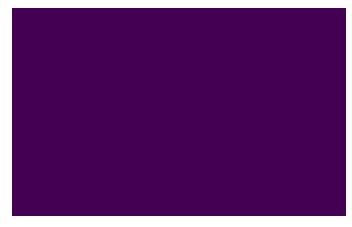

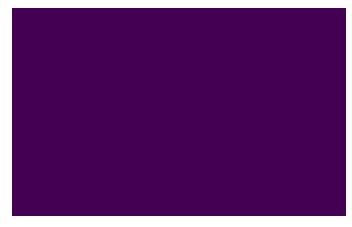

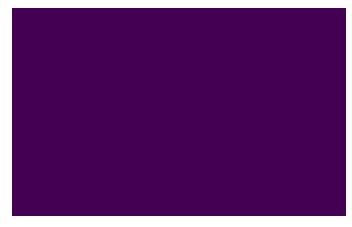

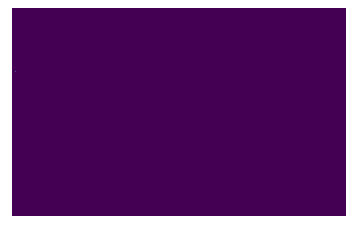

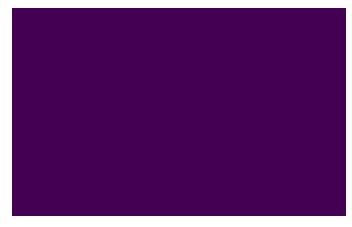

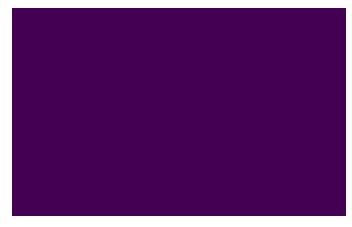

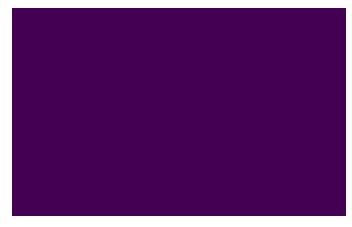

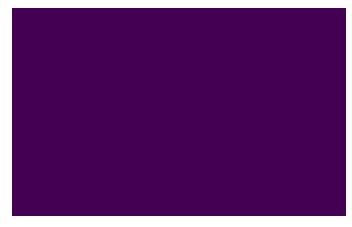

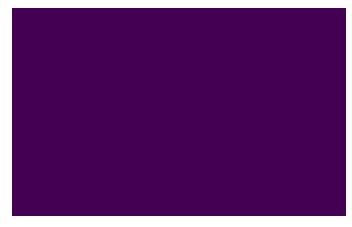

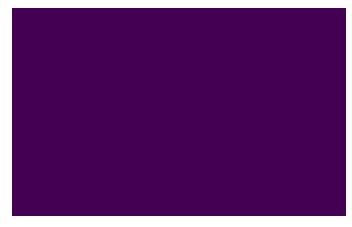

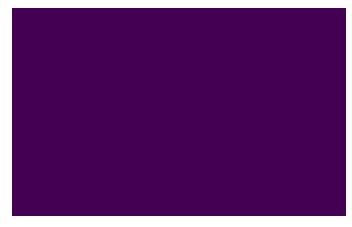

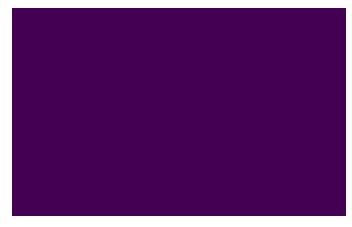

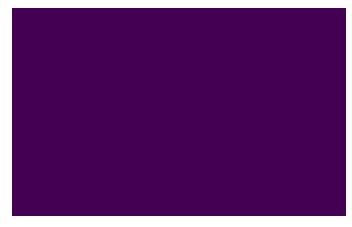

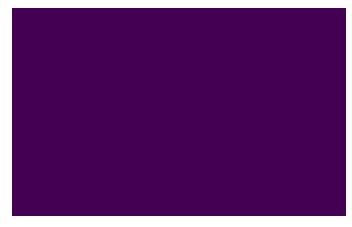

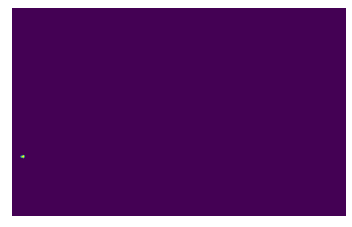

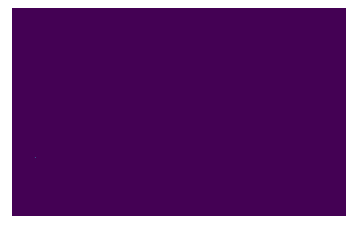

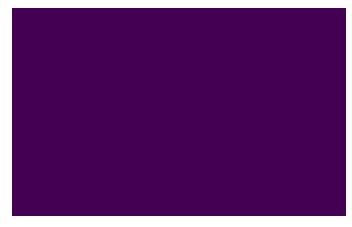

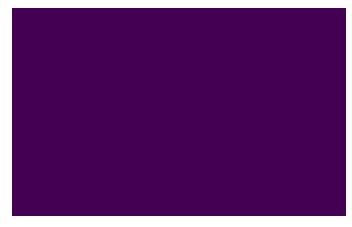

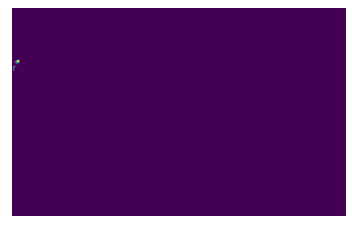

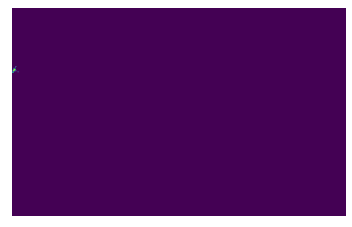

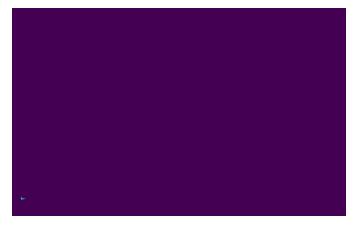

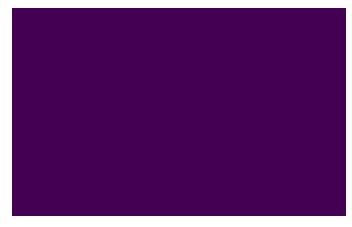

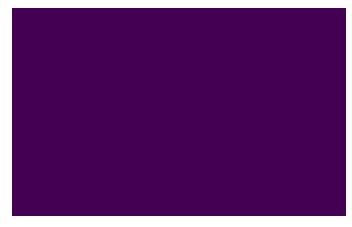

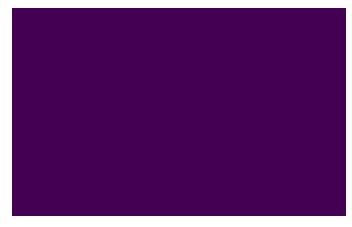

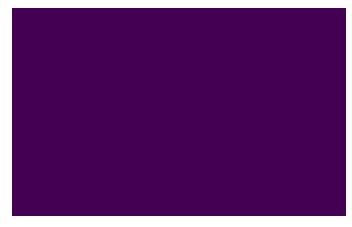

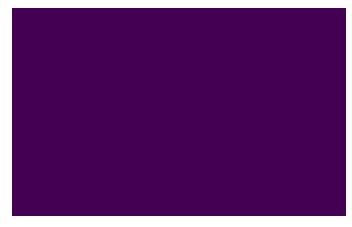

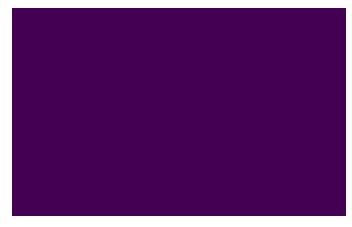

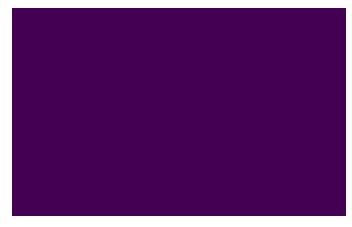

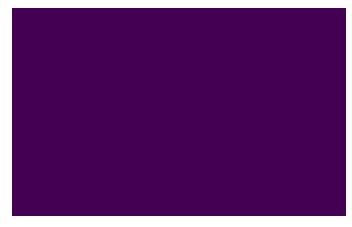

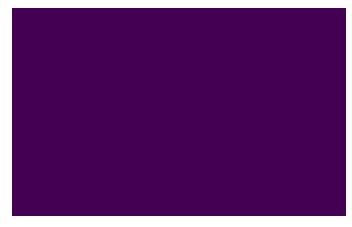

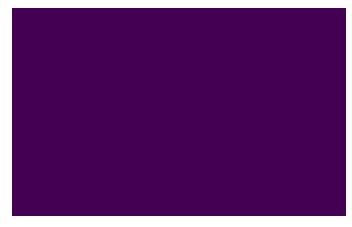

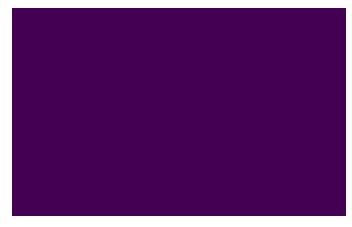

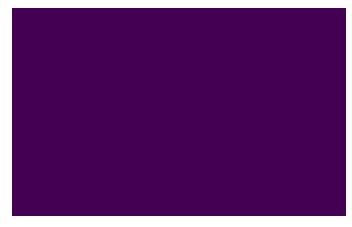

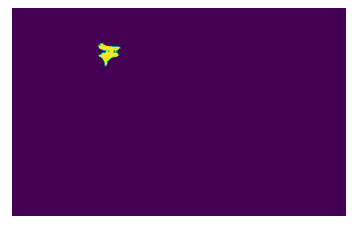

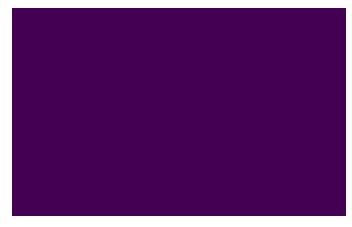

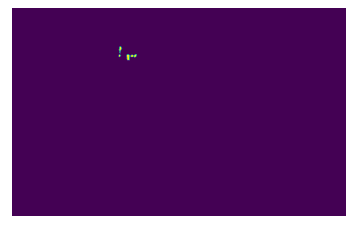

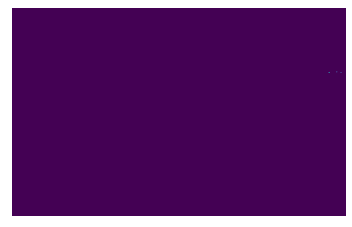

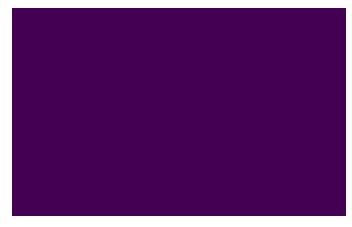

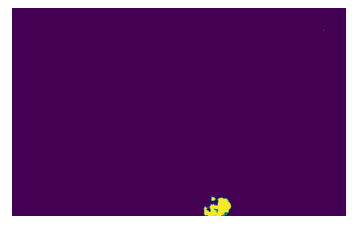

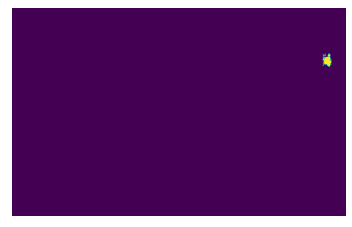

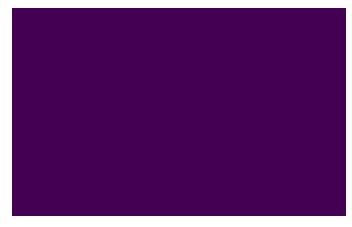

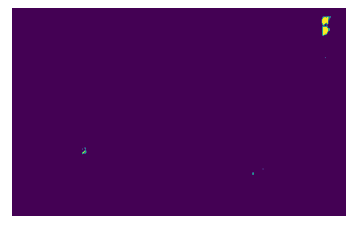

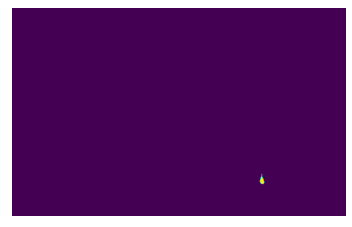

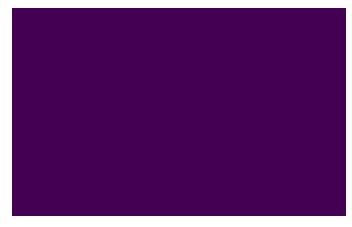

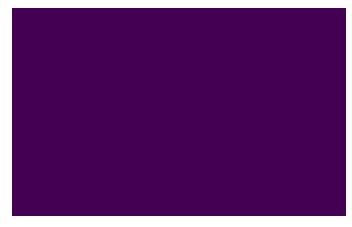

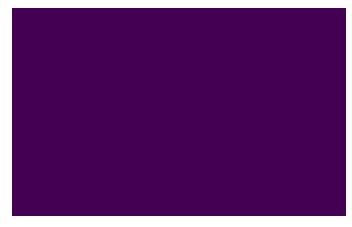

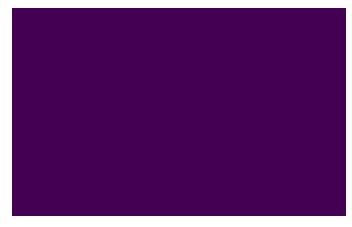

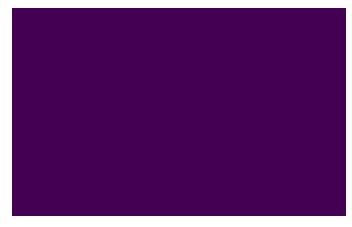

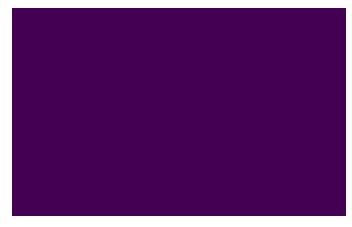

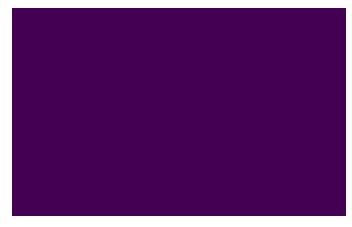

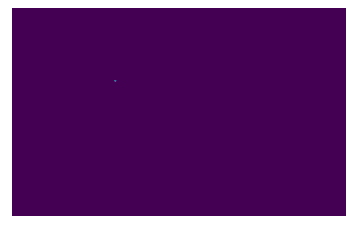

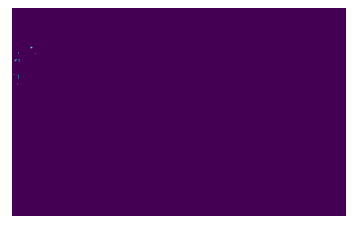

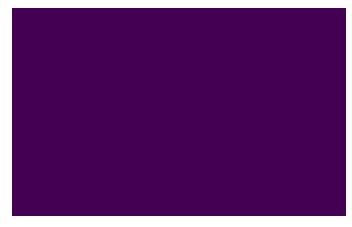

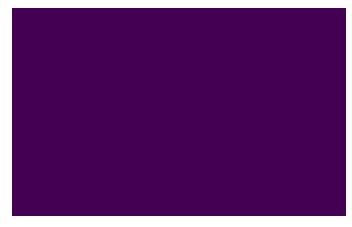

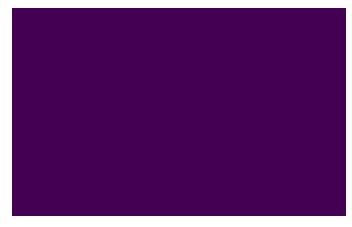

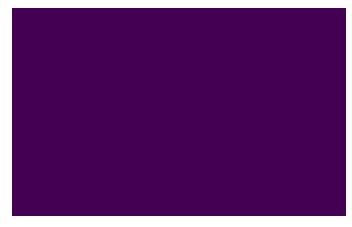

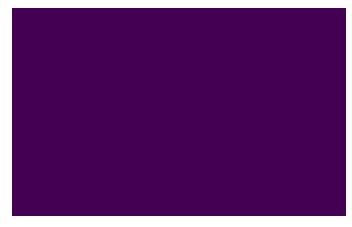

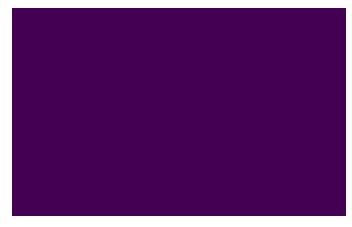

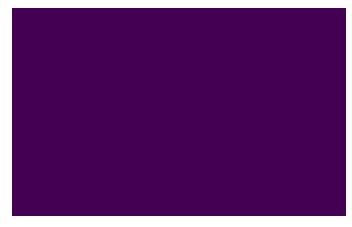

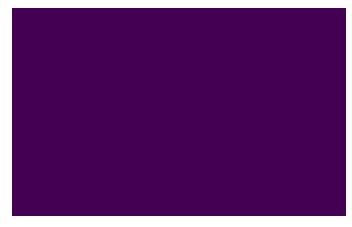

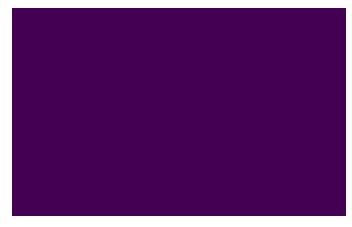

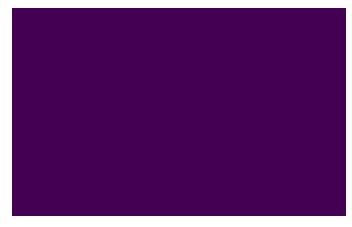

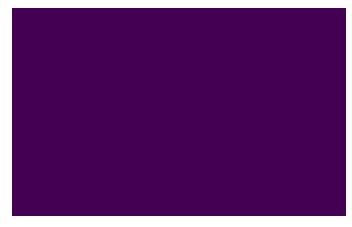

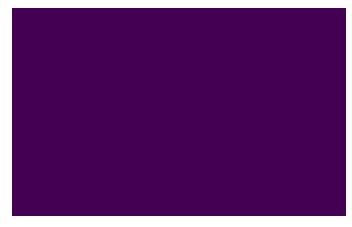

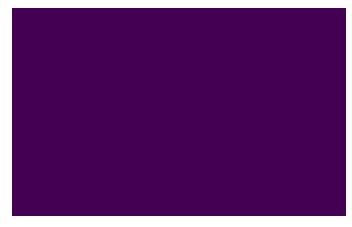

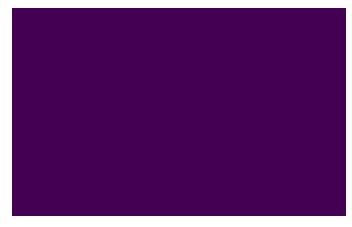

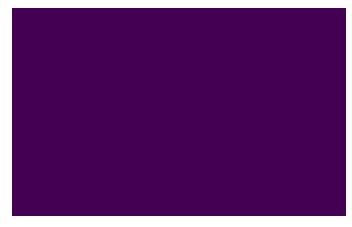

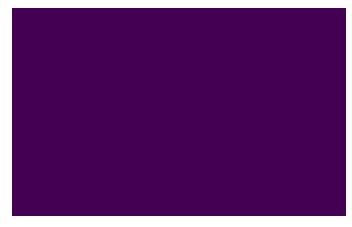

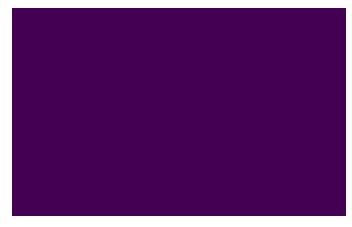

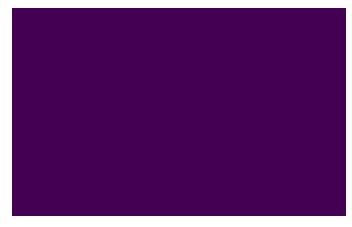

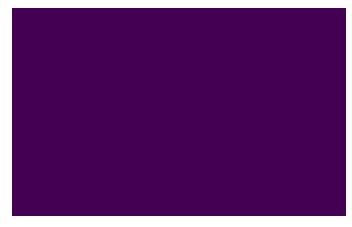

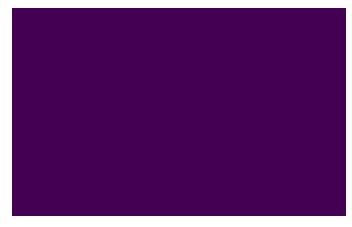

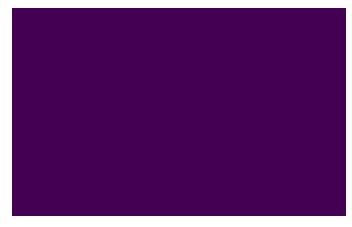

In [49]:
for n, id_ in enumerate(ids):
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.get_xaxis().set_visible(False)
    axs.get_yaxis().set_visible(False)
    axs.imshow(preds_train_t[n,...])
    plt.savefig(r'./val_mask/'+str(id_),bbox_inches="tight", pad_inches = 0, dpi=300)

In [ ]:
m,n,r = preds_train_t.shape
out_arr = np.column_stack((np.repeat(np.arange(m),n),preds_train_t.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)

In [ ]:
out_df.to_csv(r'./image.csv',index=False)

In [ ]:
out_df

In [ ]:
np.save(r'./image.npy',preds_train_t)

In [2]:
data = np.load(r'./image.npy')

In [17]:
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
for n in range(0,449,1) :
    mask = img_to_array(load_img(r"C:\Users\user\Desktop\seismic_OR\archive\mask/"+str(n)+'.png', grayscale=True))
    mask = resize(mask,(im_height,im_width, 1), mode = 'constant', preserve_range = True)
    y[n] = mask/255.0

In [19]:
y = y.reshape(449, 400, 640)

In [51]:
np.save(r'./image_true.npy',y)

In [30]:
y_pred = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
for n in range(0,449,1) :
    mask = img_to_array(load_img(r"C:\Users\user\Desktop\seismic_OR\archive\val_mask/"+str(n)+'.png', grayscale=True))
    mask = resize(mask,(im_height,im_width, 1), mode = 'constant', preserve_range = True)
    y_pred[n] = mask/255.0

In [31]:
y_pred = y_pred.reshape(449, 400, 640)

In [52]:
np.save(r'./image_pred.npy',preds_train_t)

In [24]:
data = np.load(r'./image_true.npy')
filepath = r'./image_true'

In [53]:
data = np.load(r'./image_pred.npy')
filepath = r'./image_pred'

In [25]:
import os
import matplotlib
from pyevtk.hl import gridToVTK

In [26]:
def save_to_vtk(data, filepath):
    """
    save the 3d data to a .vtk file. 
    
    Parameters
    ------------
    data : 3d np.array
        3d matrix that we want to visualize
    filepath : str
        where to save the vtk model, do not include vtk extension, it does automatically
    """
    x = np.arange(data.shape[0]+1)
    y = np.arange(data.shape[1]+1)
    z = np.arange(data.shape[2]+1)
    gridToVTK(filepath, x, y, z, cellData={'data':data.copy()})

In [54]:
save_to_vtk(data, filepath)